# **YOLOv5**

The story CONTINUED...

Using Kaggle's GPU is the same as borrow others full spec laptop to do your own work, thanks to cloud computing technologies. 

Code reference:
https://www.kaggle.com/code/saeedsarrafzadeh/yolov5-v8-object-detection

In [32]:
#Install the required file to Kaggle
!python -m pip install --upgrade pip

!pip install tensorflow

!pip install tensorboard

In [2]:
!pip install torch

In [3]:
#Libraries 

import torch #For neural networks
from IPython.display import Image #Deal with images
import random #random num 
import shutil #Provides functions for file operations, such as copying and deleting files.

## Clone the YOLOv5 repository:

In [4]:
%cd {/kaggle/working/}

[Errno 2] No such file or directory: '{/kaggle/working/}'
/kaggle/working


In [5]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 16605, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 16605 (delta 50), reused 96 (delta 43), pack-reused 16459
Receiving objects: 100% (16605/16605), 15.27 MiB | 27.88 MiB/s, done.
Resolving deltas: 100% (11356/11356), done.


In [6]:
%cd yolov5

/kaggle/working/yolov5


In [7]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 618.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 41.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0

# Data Pre-processing 

**Convert** labels(.csv) to labels(.txt) for Yolov5 standard

In [8]:
import pandas as pd  # Importing the pandas library and aliasing it as 'pd' for easier reference.
import os            # Importing the os module for operating system-related functionalities.


In [9]:
image_width = 480
image_height = 300
############ SIMILAR LOGIC ####################

# Replace 'path_to_your_csv.csv' with the actual path to your CSV file
csv_path = '/kaggle/input/self-driving-cars/labels_trainval.csv'

# Read CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Create a dictionary to store annotations for each image
annotations_dict = {}

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    frame = row['frame']
    class_id = row['class_id']
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

    # Calculate YOLO format values
    width = (xmax - xmin)/image_width
    height = (ymax - ymin)/image_height
    x_center = ((xmax + xmin) / 2)/image_width
    y_center = ((ymax + ymin) / 2)/image_height

    # Create or append to the annotations for the image
    if frame not in annotations_dict:
        annotations_dict[frame] = []
    annotations_dict[frame].append(f"{class_id} {x_center} {y_center} {width} {height}")

# Define the output folder for YOLO format files
output_folder = '/kaggle/working/labels'
os.makedirs(output_folder, exist_ok=True)

# Write YOLO format files
count_txt_val = 0
for frame, annotations in annotations_dict.items():
    output_path = os.path.join(output_folder, os.path.splitext(frame)[0] + '.txt')
    count_txt_val+=1
    with open(output_path, 'w') as file:
        for annotation in annotations:
            file.write(annotation + '\n')

print("Conversion complete.")
print(count_txt_val)

Conversion complete.
22241


In [10]:
# count total Image dataset and check with number of txt file
import glob

# Path to the directory containing images
image_folder = '/kaggle/input/self-driving-cars/images'

# Using glob to find all files with the .jpg extension
jpg_files = glob.glob(image_folder + '/*.jpg')

# Counting the number of files with the .jpg extension
num_jpg_files = len(jpg_files)

print(f"Number of files with the .jpg extension: {num_jpg_files}")

if count_txt_val==num_jpg_files:
  print("number of images and labels is equal")
else:
  print ("number of images and labels is'nt equal")

Number of files with the .jpg extension: 22241
number of images and labels is equal


### Make foldering dataset for yolov5 standard


In [11]:
import os
import random
from concurrent.futures import ProcessPoolExecutor

# Define paths
images_folder = '/kaggle/input/self-driving-cars/images' # Folder containing images to be grouped with labels
labels_folder = '/kaggle/working/labels' # Folder containing labels in YOLO format
train_folder = '/kaggle/working/data/images/train/' # Destination folder for training images and labels
validation_folder = '/kaggle/working/data/images/validation/' # Destination folder for validation images and labels

# Get lists of images and labels
images = os.listdir(images_folder) # List of filenames in the images folder
labels = os.listdir(labels_folder) # List of filenames in the labels folder

# Split images and labels into train and validation sets
split_ratio = 0.8
images_to_train = [image for image in images if random.random() < split_ratio] # Randomly select images for training
images_to_validate = list(set(images) - set(images_to_train)) # Remaining images for validation
labels_to_train = [label for label in labels if label.split('.')[0] in images_to_train]  # Match labels to images for training
labels_to_validate = list(set(labels) - set(labels_to_train)) # Labels corresponding to validation images

# Make sure destination folders exist
for folder in [train_folder, validation_folder]:
  os.makedirs(os.path.join(folder, 'images'), exist_ok=True) # Create subfolders for images
  os.makedirs(os.path.join(folder, 'labels'), exist_ok=True) # Create subfolders for labels

# Define a function to copy a single image and label pair
def copy_file(source_image, source_label, destination_images, destination_labels):
  shutil.copyfile(os.path.join(images_folder, source_image), os.path.join(destination_images, source_image)) # Copy image file
  shutil.copyfile(os.path.join(labels_folder, source_label), os.path.join(destination_labels, source_label)) # Copy label file

# Use multiprocessing to copy files in parallel
with ProcessPoolExecutor() as executor:
  tasks = []

  # Prepare tasks for train set
  for image in images_to_train:
    label = image.replace('.jpg', '.txt') # Replace image extension with label extension
    tasks.append(executor.submit(copy_file, image, label, os.path.join(train_folder, 'images'), os.path.join(train_folder, 'labels')))

  # Prepare tasks for validation set
  for image in images_to_validate:
    label = image.replace('.jpg', '.txt') # Replace image extension with label extension
    tasks.append(executor.submit(copy_file, image, label, os.path.join(validation_folder, 'images'), os.path.join(validation_folder, 'labels')))

  # Wait for all tasks to finish
  for future in tasks:
    future.result()

print("File copying completed!")


File copying completed!


In [12]:
# count number of file to thease destination:

# train_folder = '/kaggle/working/data/images/train'
# validation_folder = '/kaggle/working/data/images/validation'

# Count number of files in train and validation folders
num_train_images = len(os.listdir(os.path.join(train_folder, 'images')))
num_train_labels = len(os.listdir(os.path.join(train_folder, 'labels')))
num_validation_images = len(os.listdir(os.path.join(validation_folder, 'images')))
num_validation_labels = len(os.listdir(os.path.join(validation_folder, 'labels')))

# Print the counts
print(f"Number of training images: {num_train_images}")
print(f"Number of training labels: {num_train_labels}")
print(f"Number of validation images: {num_validation_images}")
print(f"Number of validation labels: {num_validation_labels}")


Number of training images: 17764
Number of training labels: 17764
Number of validation images: 4477
Number of validation labels: 4477


In [13]:
# check randomly in train and validation folders, that copied the same name of ".jpg" and ".txt" file to the same folder

import random

# Define the folders to check
train_images_folder = '/kaggle/working/data/images/train/images'
train_labels_folder = '/kaggle/working/data/images/train/labels'
validation_images_folder = '/kaggle/working/data/images/validation/images'
validation_labels_folder = '/kaggle/working/data/images/validation/labels'

# Get lists of files in each folder
train_images = os.listdir(train_images_folder)
train_labels = os.listdir(train_labels_folder)
validation_images = os.listdir(validation_images_folder)
validation_labels = os.listdir(validation_labels_folder)

# Check 10 random files in train folder
for _ in range(10):
  # Choose a random image
  image_index = random.randint(0, len(train_images) - 1)
  image_filename = train_images[image_index]

  # Check if the corresponding label file exists
  label_filename = image_filename.replace('.jpg', '.txt')
  assert label_filename in train_labels, f"Missing label file for image: {image_filename}"

# Check 10 random files in validation folder
for _ in range(10):
  # Choose a random image
  image_index = random.randint(0, len(validation_images) - 1)
  image_filename = validation_images[image_index]

  # Check if the corresponding label file exists
  label_filename = image_filename.replace('.jpg', '.txt')
  assert label_filename in validation_labels, f"Missing label file for image: {image_filename}"

print("Random checks passed. It seems that the files have been copied correctly.")


Random checks passed. It seems that the files have been copied correctly.


# Par1 - Use pre-trained Yolov5

In [14]:
!python detect.py --weights yolov5m.pt --conf-thres 0.5 --line-thickness 2 --source "/kaggle/input/self-driving-cars/images/1478019955679801306.jpg"

detect: weights=['yolov5m.pt'], source=/kaggle/input/self-driving-cars/images/1478019955679801306.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
WARNING ⚠️ invalid check_version(None, >=3.3) requested, please check values.
YOLOv5 🚀 v7.0-321-g3742ab49 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

100%|███████████████████████████████████████| 40.8M/40.8M [00:00<00:00, 229MB/s]

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
image 1/1 /kaggle/input/self-driving-cars/images/1478019955679801306.jpg: 416x640 2 trucks, 67.1ms
Speed: 2.1ms pre-process, 67.1ms inference, 514.9ms

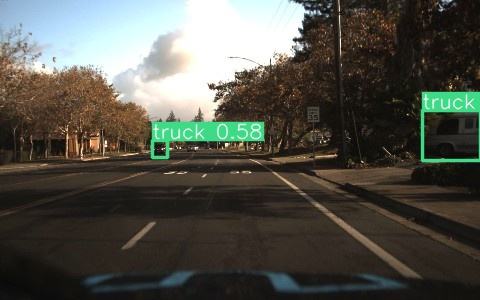

In [15]:
Image('/kaggle/working/yolov5/runs/detect/exp/1478019955679801306.jpg')

In [17]:
!python detect.py --weights yolov5m.pt --conf-thres 0.5 --line-thickness 2 --source "/kaggle/input/self-driving-cars/images/1478020427201770556.jpg"

detect: weights=['yolov5m.pt'], source=/kaggle/input/self-driving-cars/images/1478020427201770556.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
WARNING ⚠️ invalid check_version(None, >=3.3) requested, please check values.
YOLOv5 🚀 v7.0-321-g3742ab49 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /kaggle/input/self-driving-cars/images/1478020427201770556.jpg: 416x640 4 cars, 9 traffic lights, 57.3ms
Speed: 0.5ms pre-process, 57.3ms inference, 621.5ms NMS per image at shape 

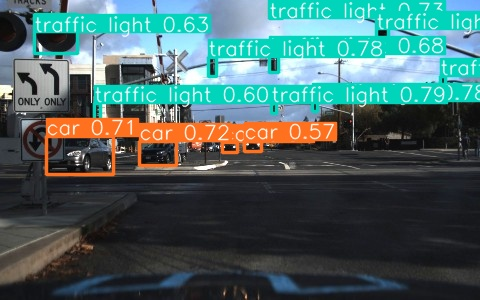

In [18]:

Image('/kaggle/working/yolov5/runs/detect/exp2/1478020427201770556.jpg')

# Part 2 - Train the model


#### Make dataset.yml file for yolov5

In [19]:
import os

# Define paths
output_folder = '/kaggle/working/yolov5/data'

# Create dataset.yaml content
dataset_yaml_content = """
# train and val and test data
train: /kaggle/working/data/images/train/
val: /kaggle/working/data/images/validation/


# number of classes
nc: 6

# Class name
names: [ 'nothing' , 'car', 'truck', 'pedestrian', 'bicyclist', 'light']
"""

# Save dataset.yaml file
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'dataset2.yaml'), 'w') as f:
    f.write(dataset_yaml_content)

print("dataset.yaml file created successfully1.")

dataset.yaml file created successfully1.


In [20]:
%cd yolov5


[Errno 2] No such file or directory: 'yolov5'
/kaggle/working/yolov5


In [21]:
!python train.py --img 480 --batch 16 --epochs 20 --data dataset2.yaml --weights yolov5n.pt --cache 

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-10 12:18:59.417460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 12:18:59.417568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 12:18:59.520890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train:

In [ ]:
'''# prompt: copy a folder from direction to another direction with shutil . if folder exist, then replace it updated folder

import shutil

# Define source and destination paths
source_folder = '/content/kaggle/yolov5/runs/train'
destination_folder = '/content/gdrive/MyDrive/kaggle/yolov5_train_results/runs/train/'

# Check if destination folder exists
if os.path.exists(destination_folder):
  # Remove the existing destination folder
  shutil.rmtree(destination_folder)

# Copy the source folder to the destination
shutil.copytree(source_folder, destination_folder)

print("Folder copied successfully.")
'''

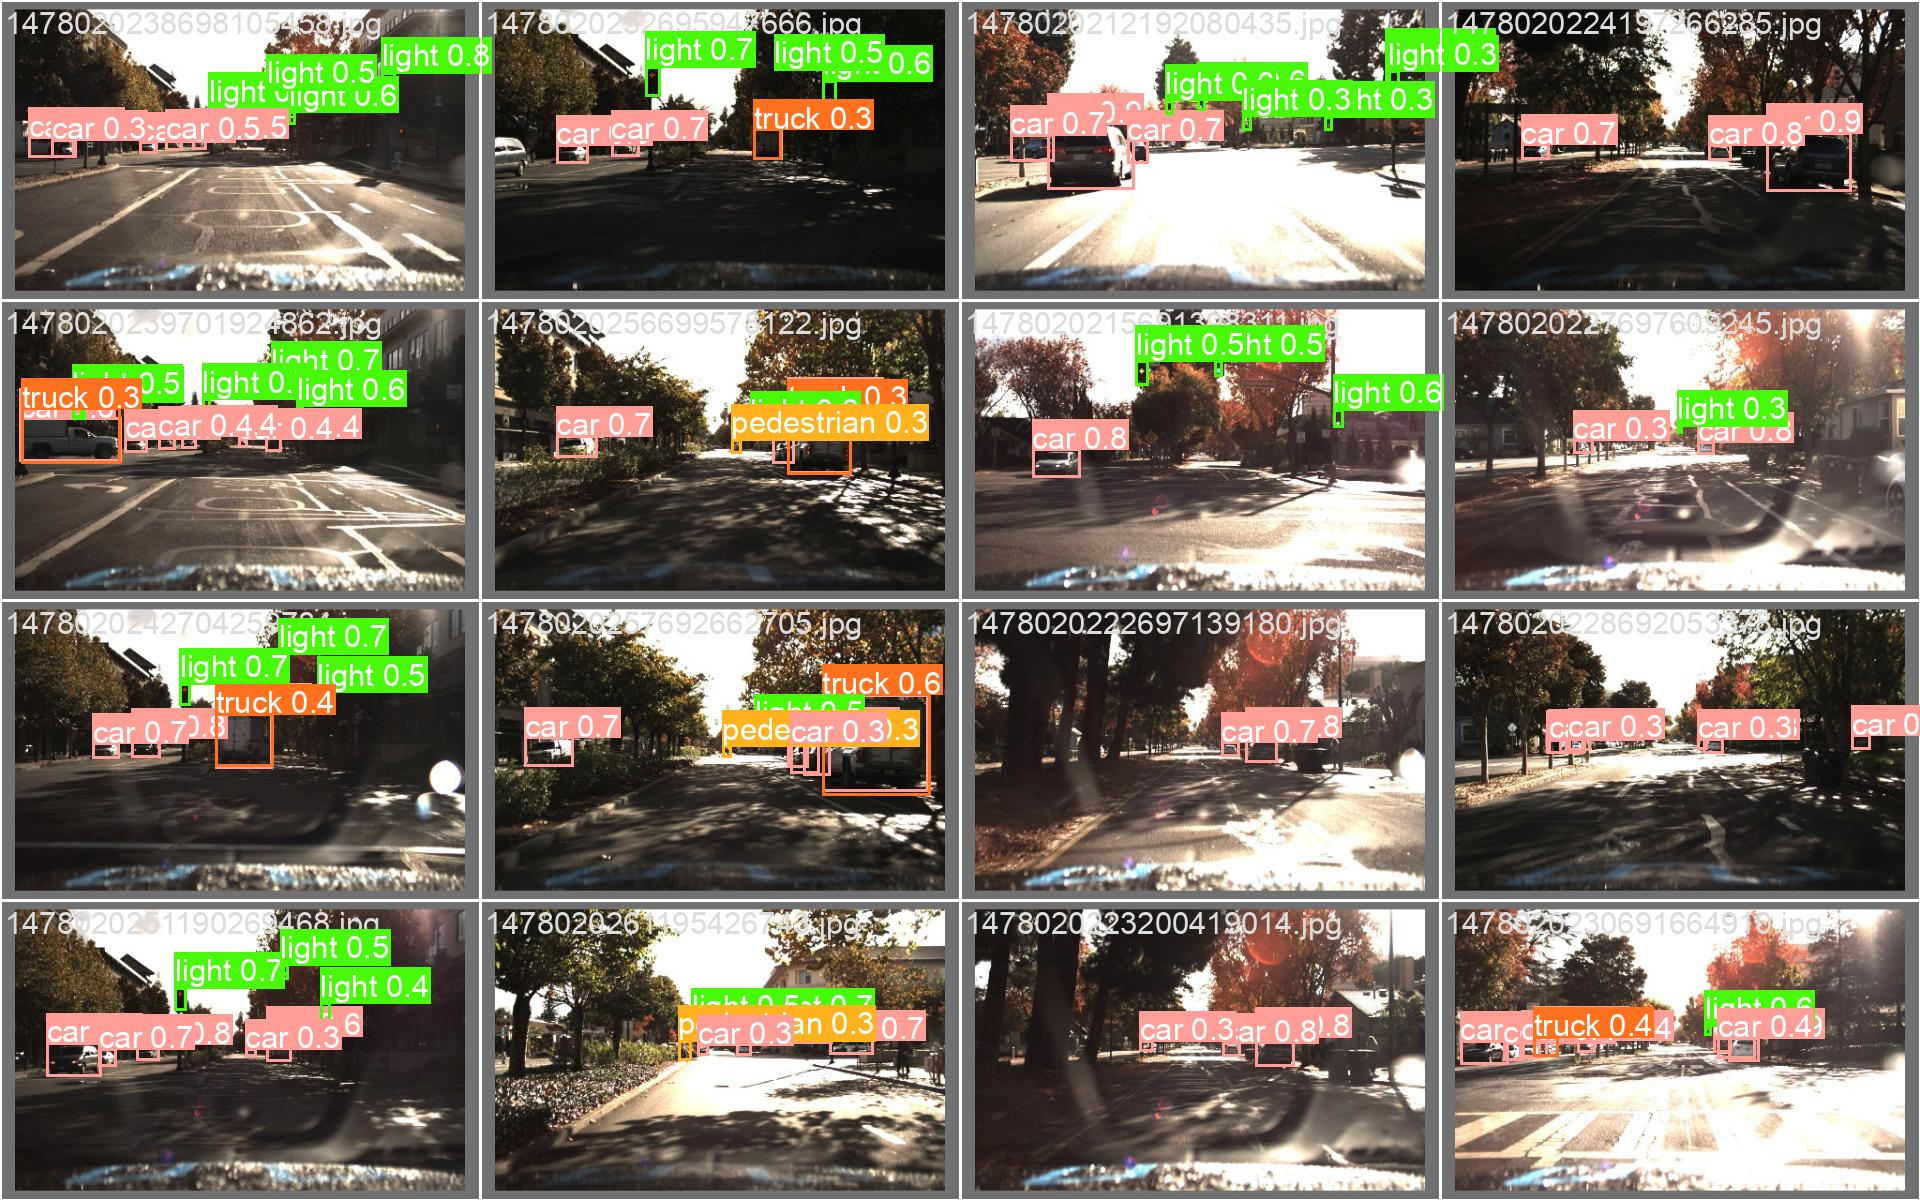

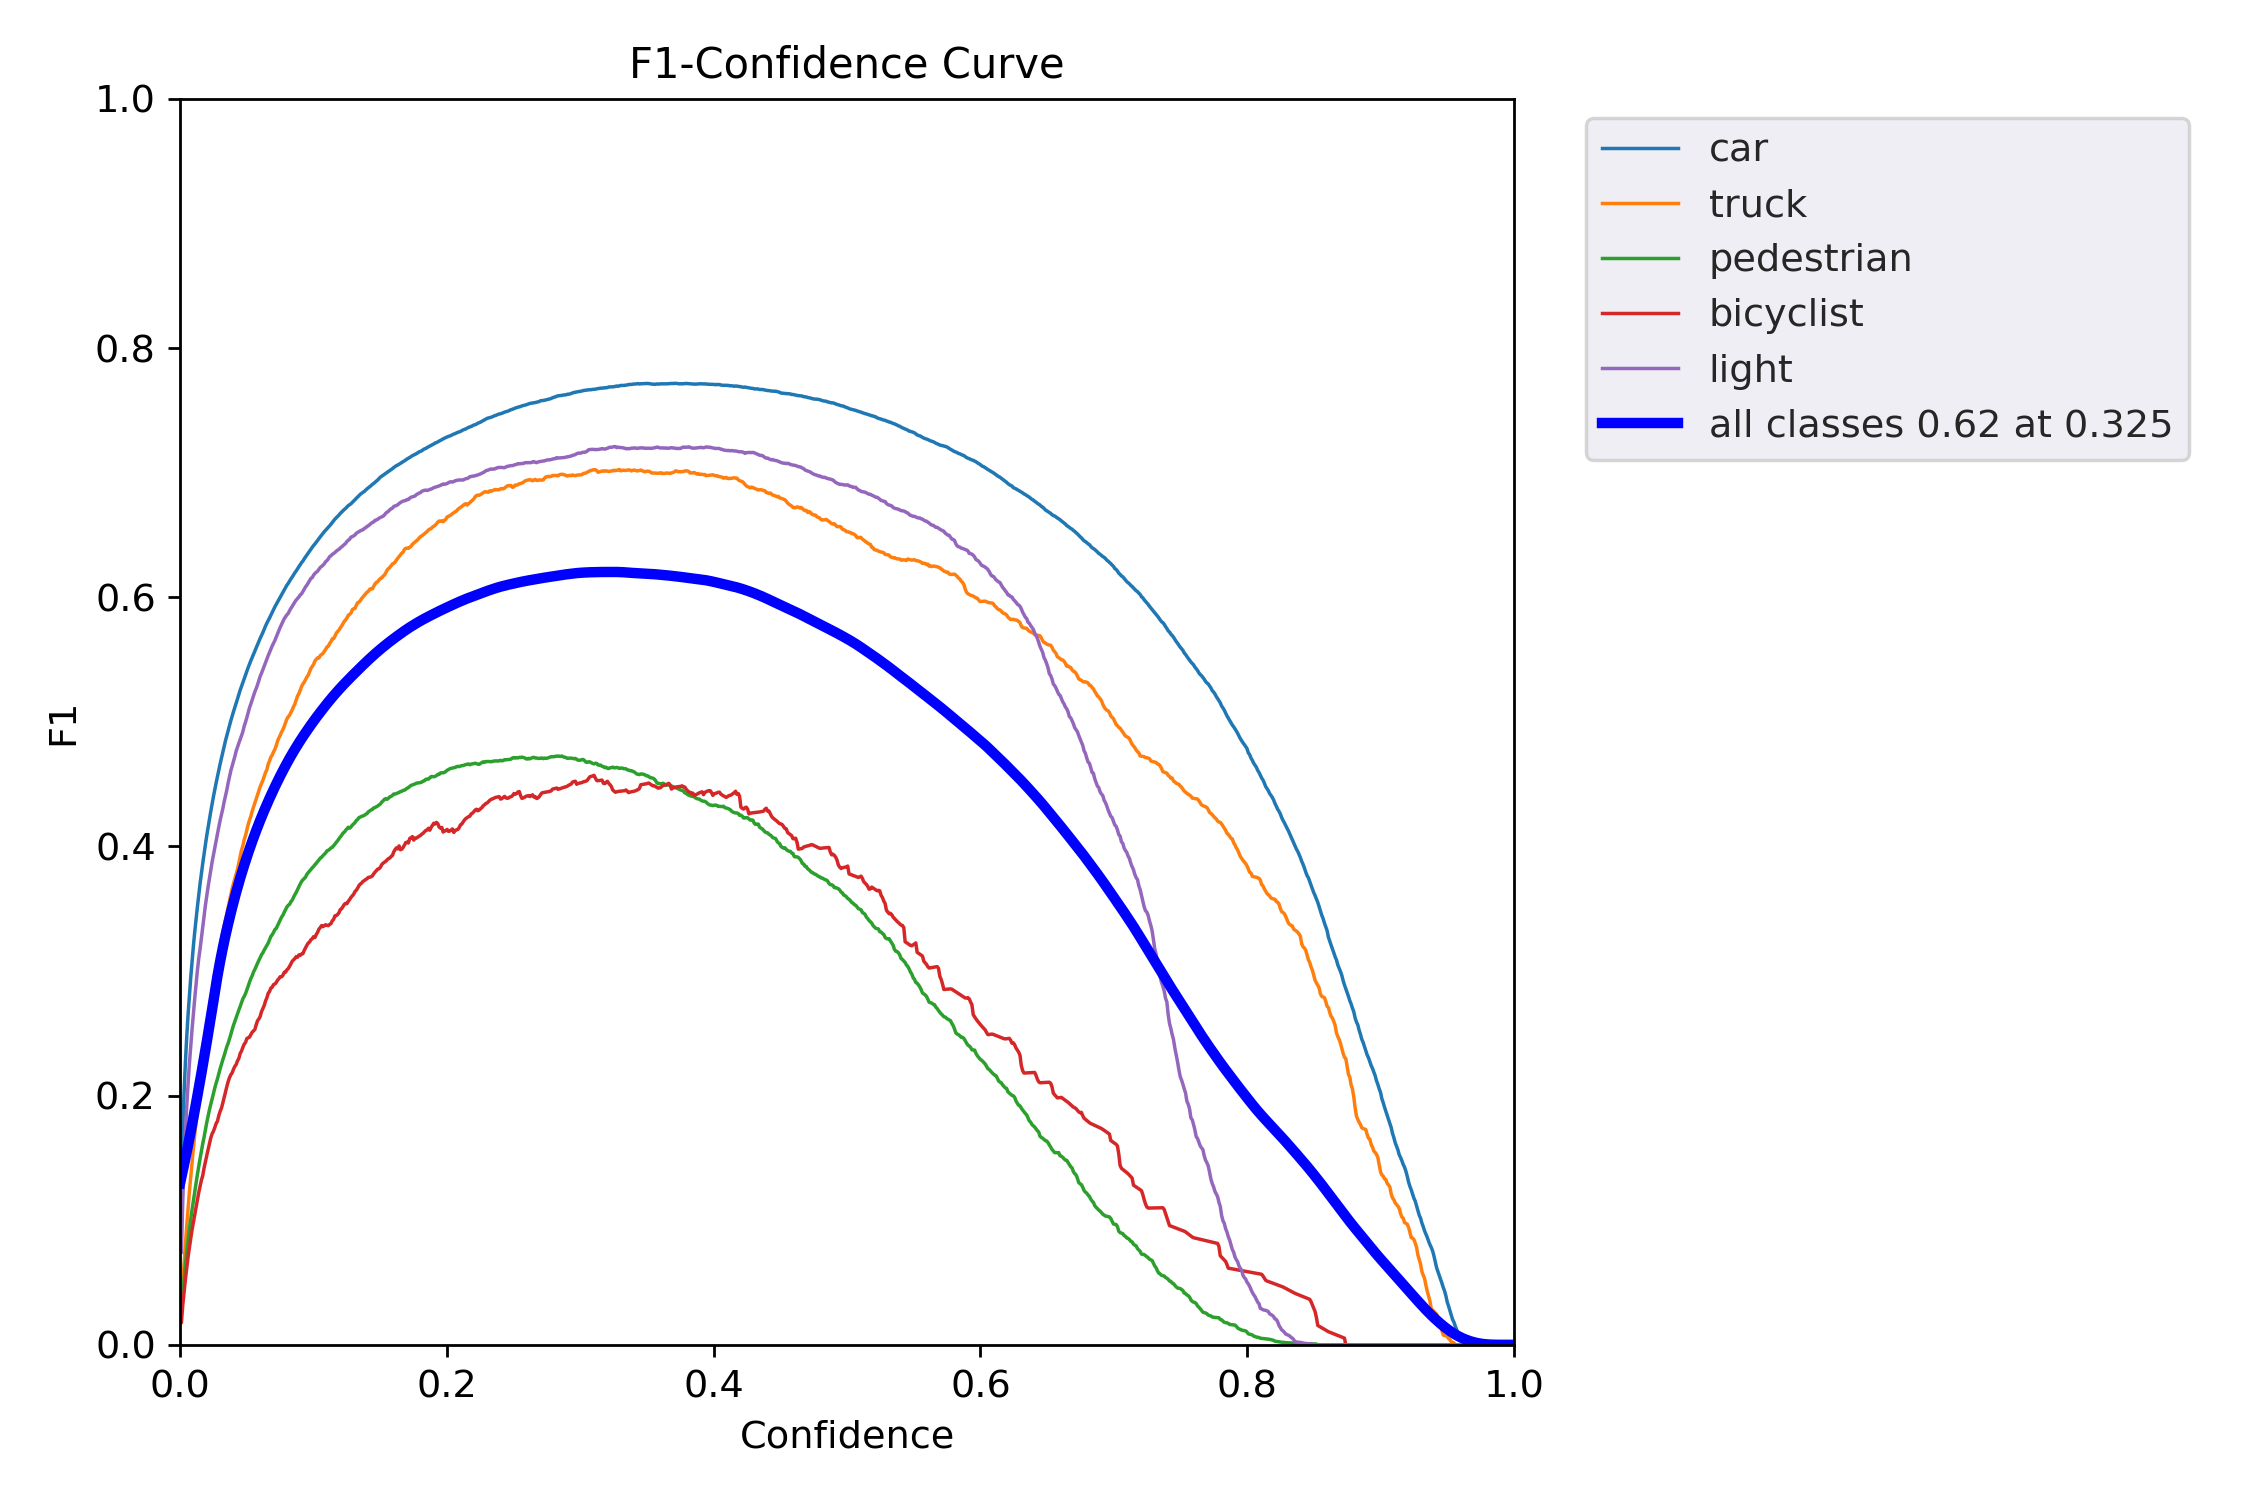

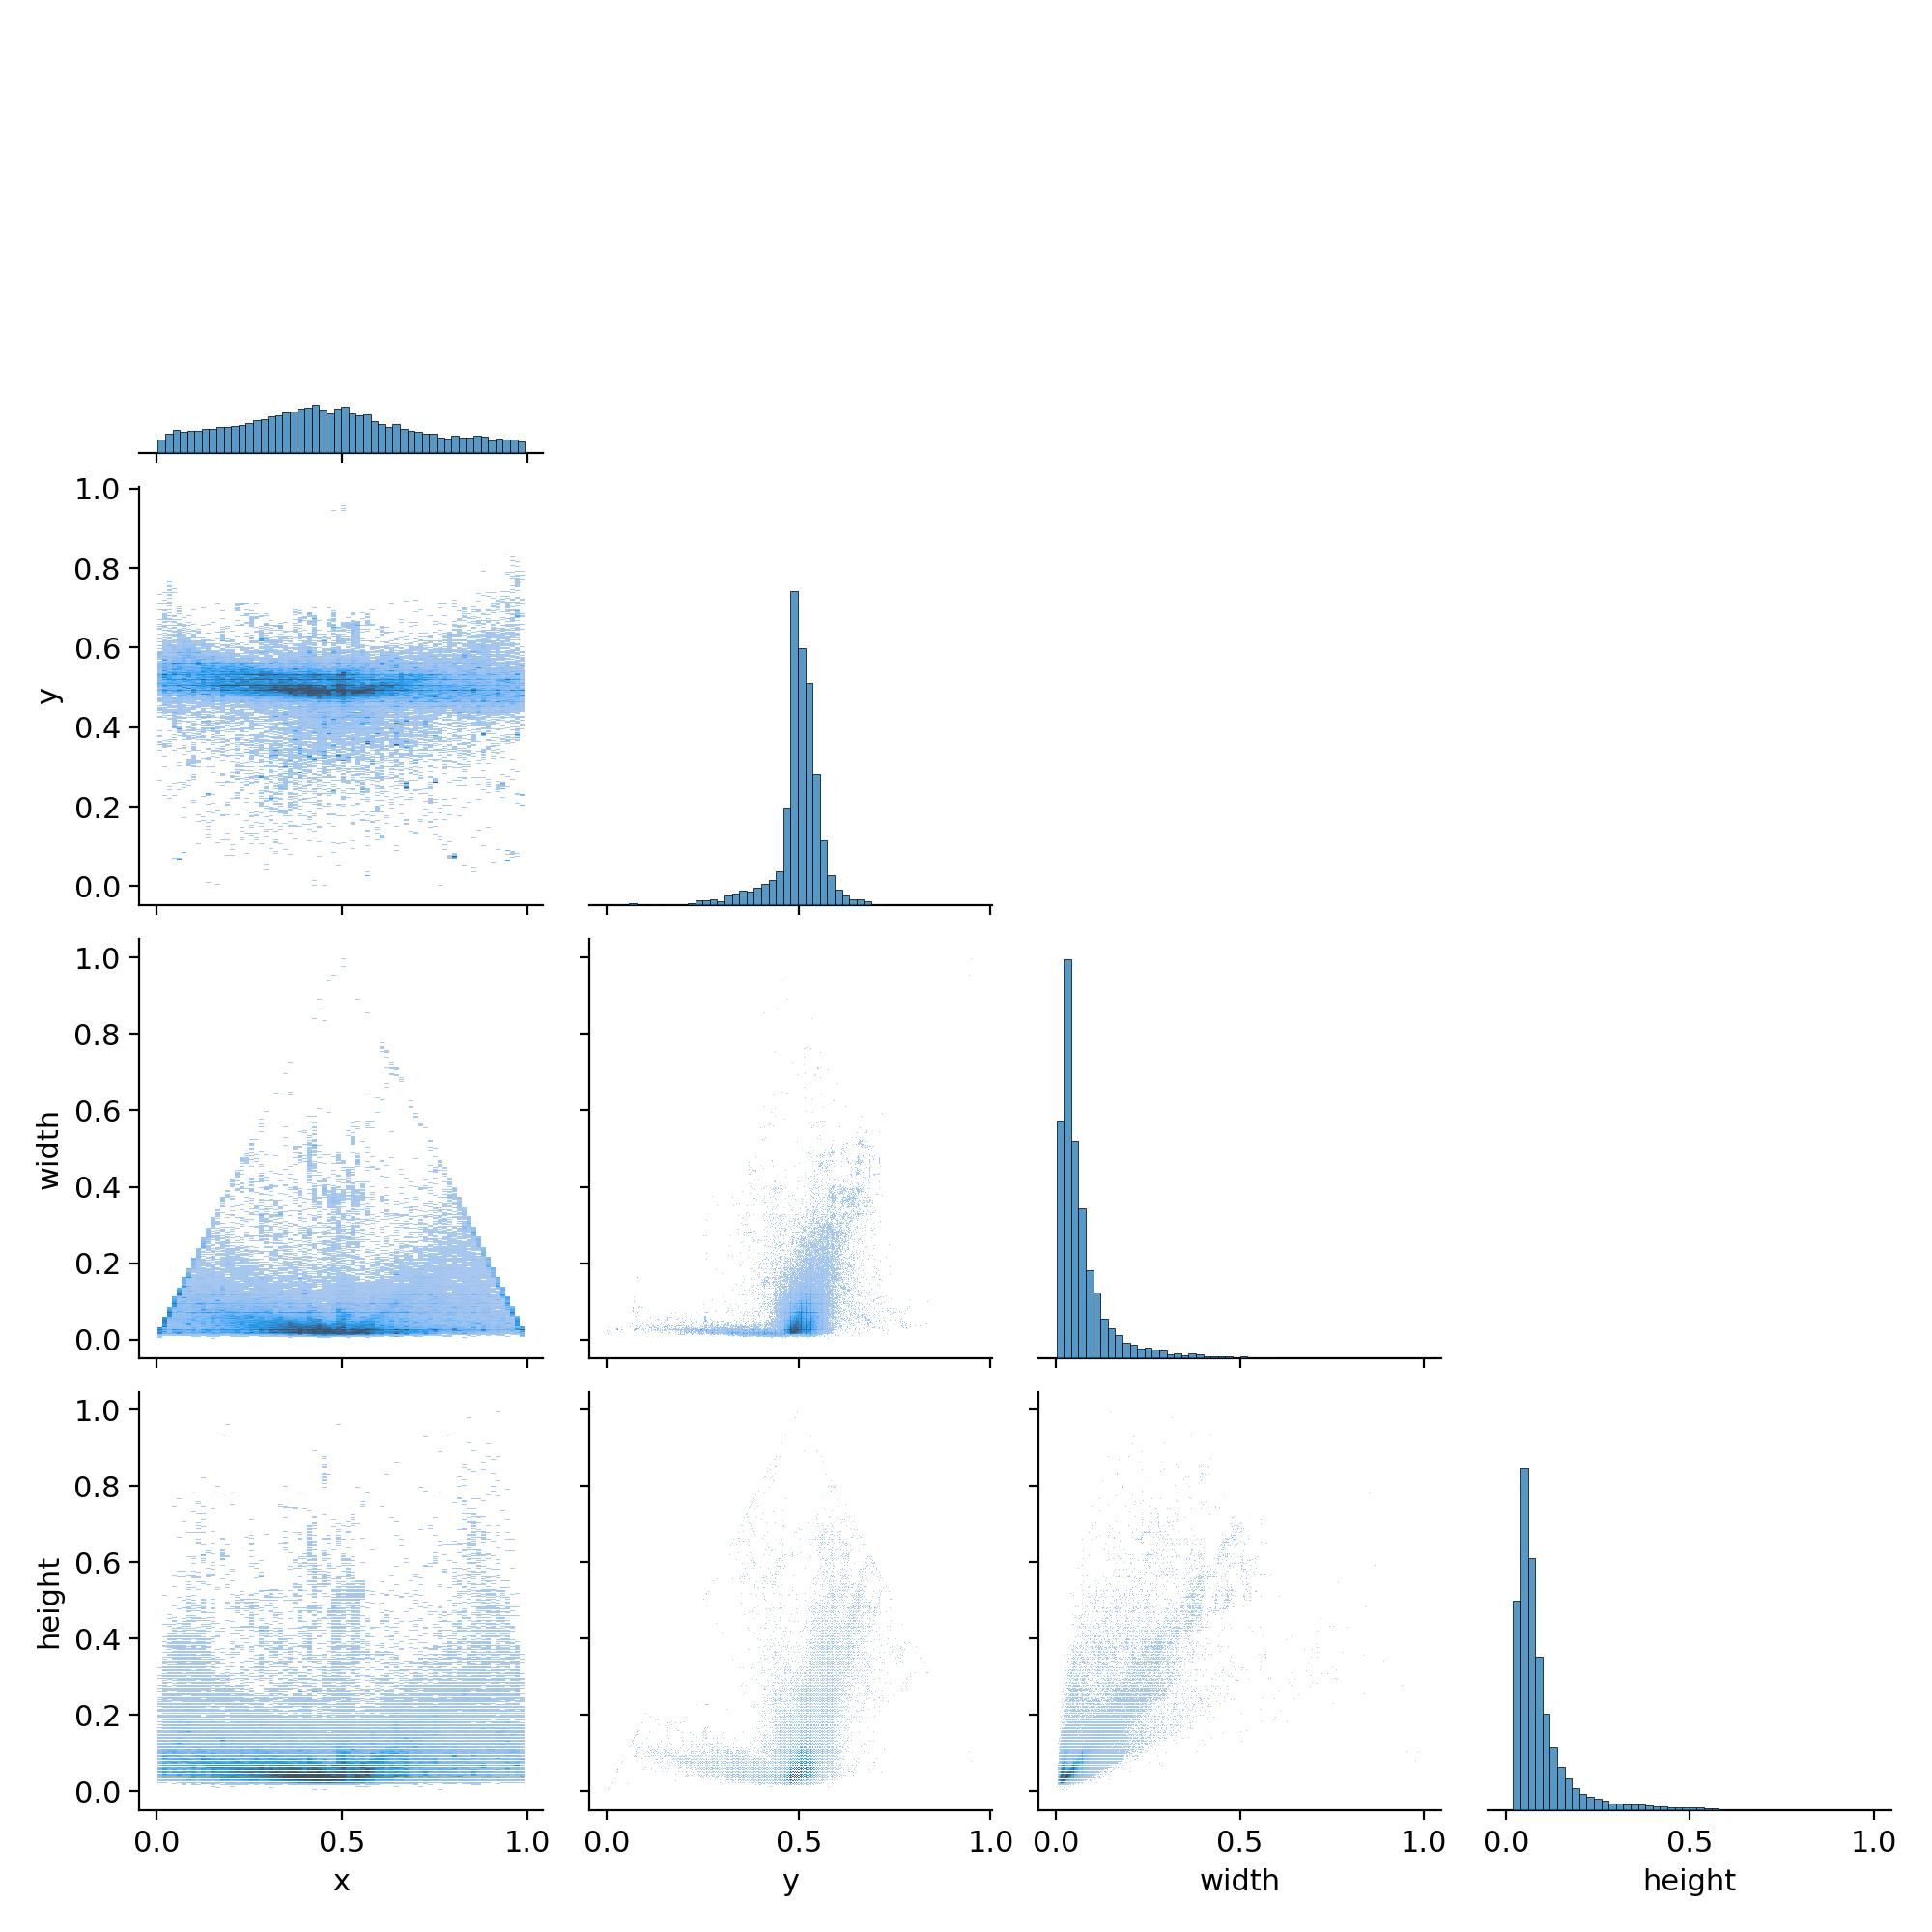

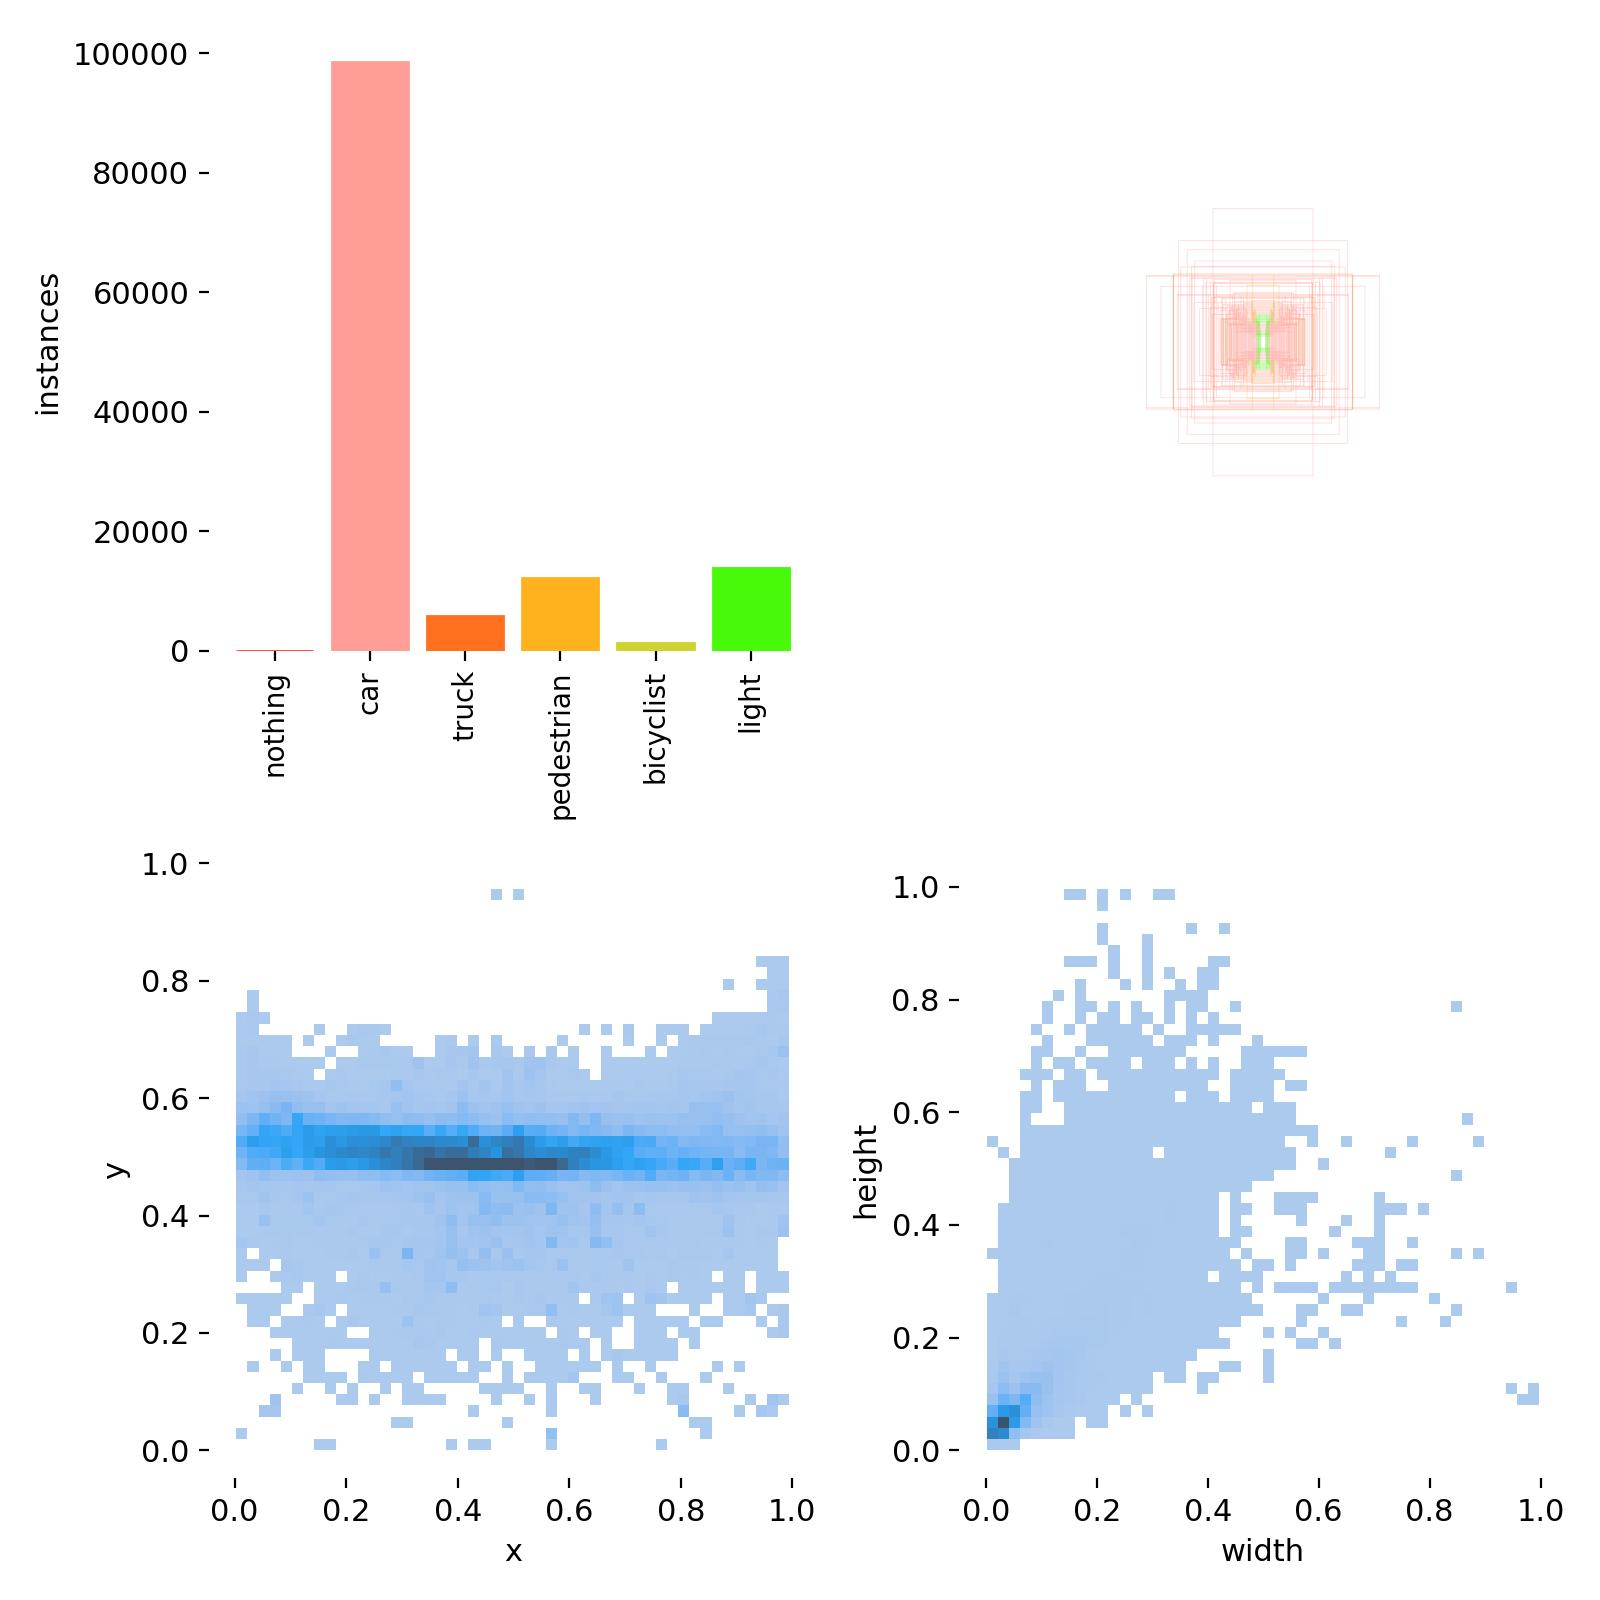

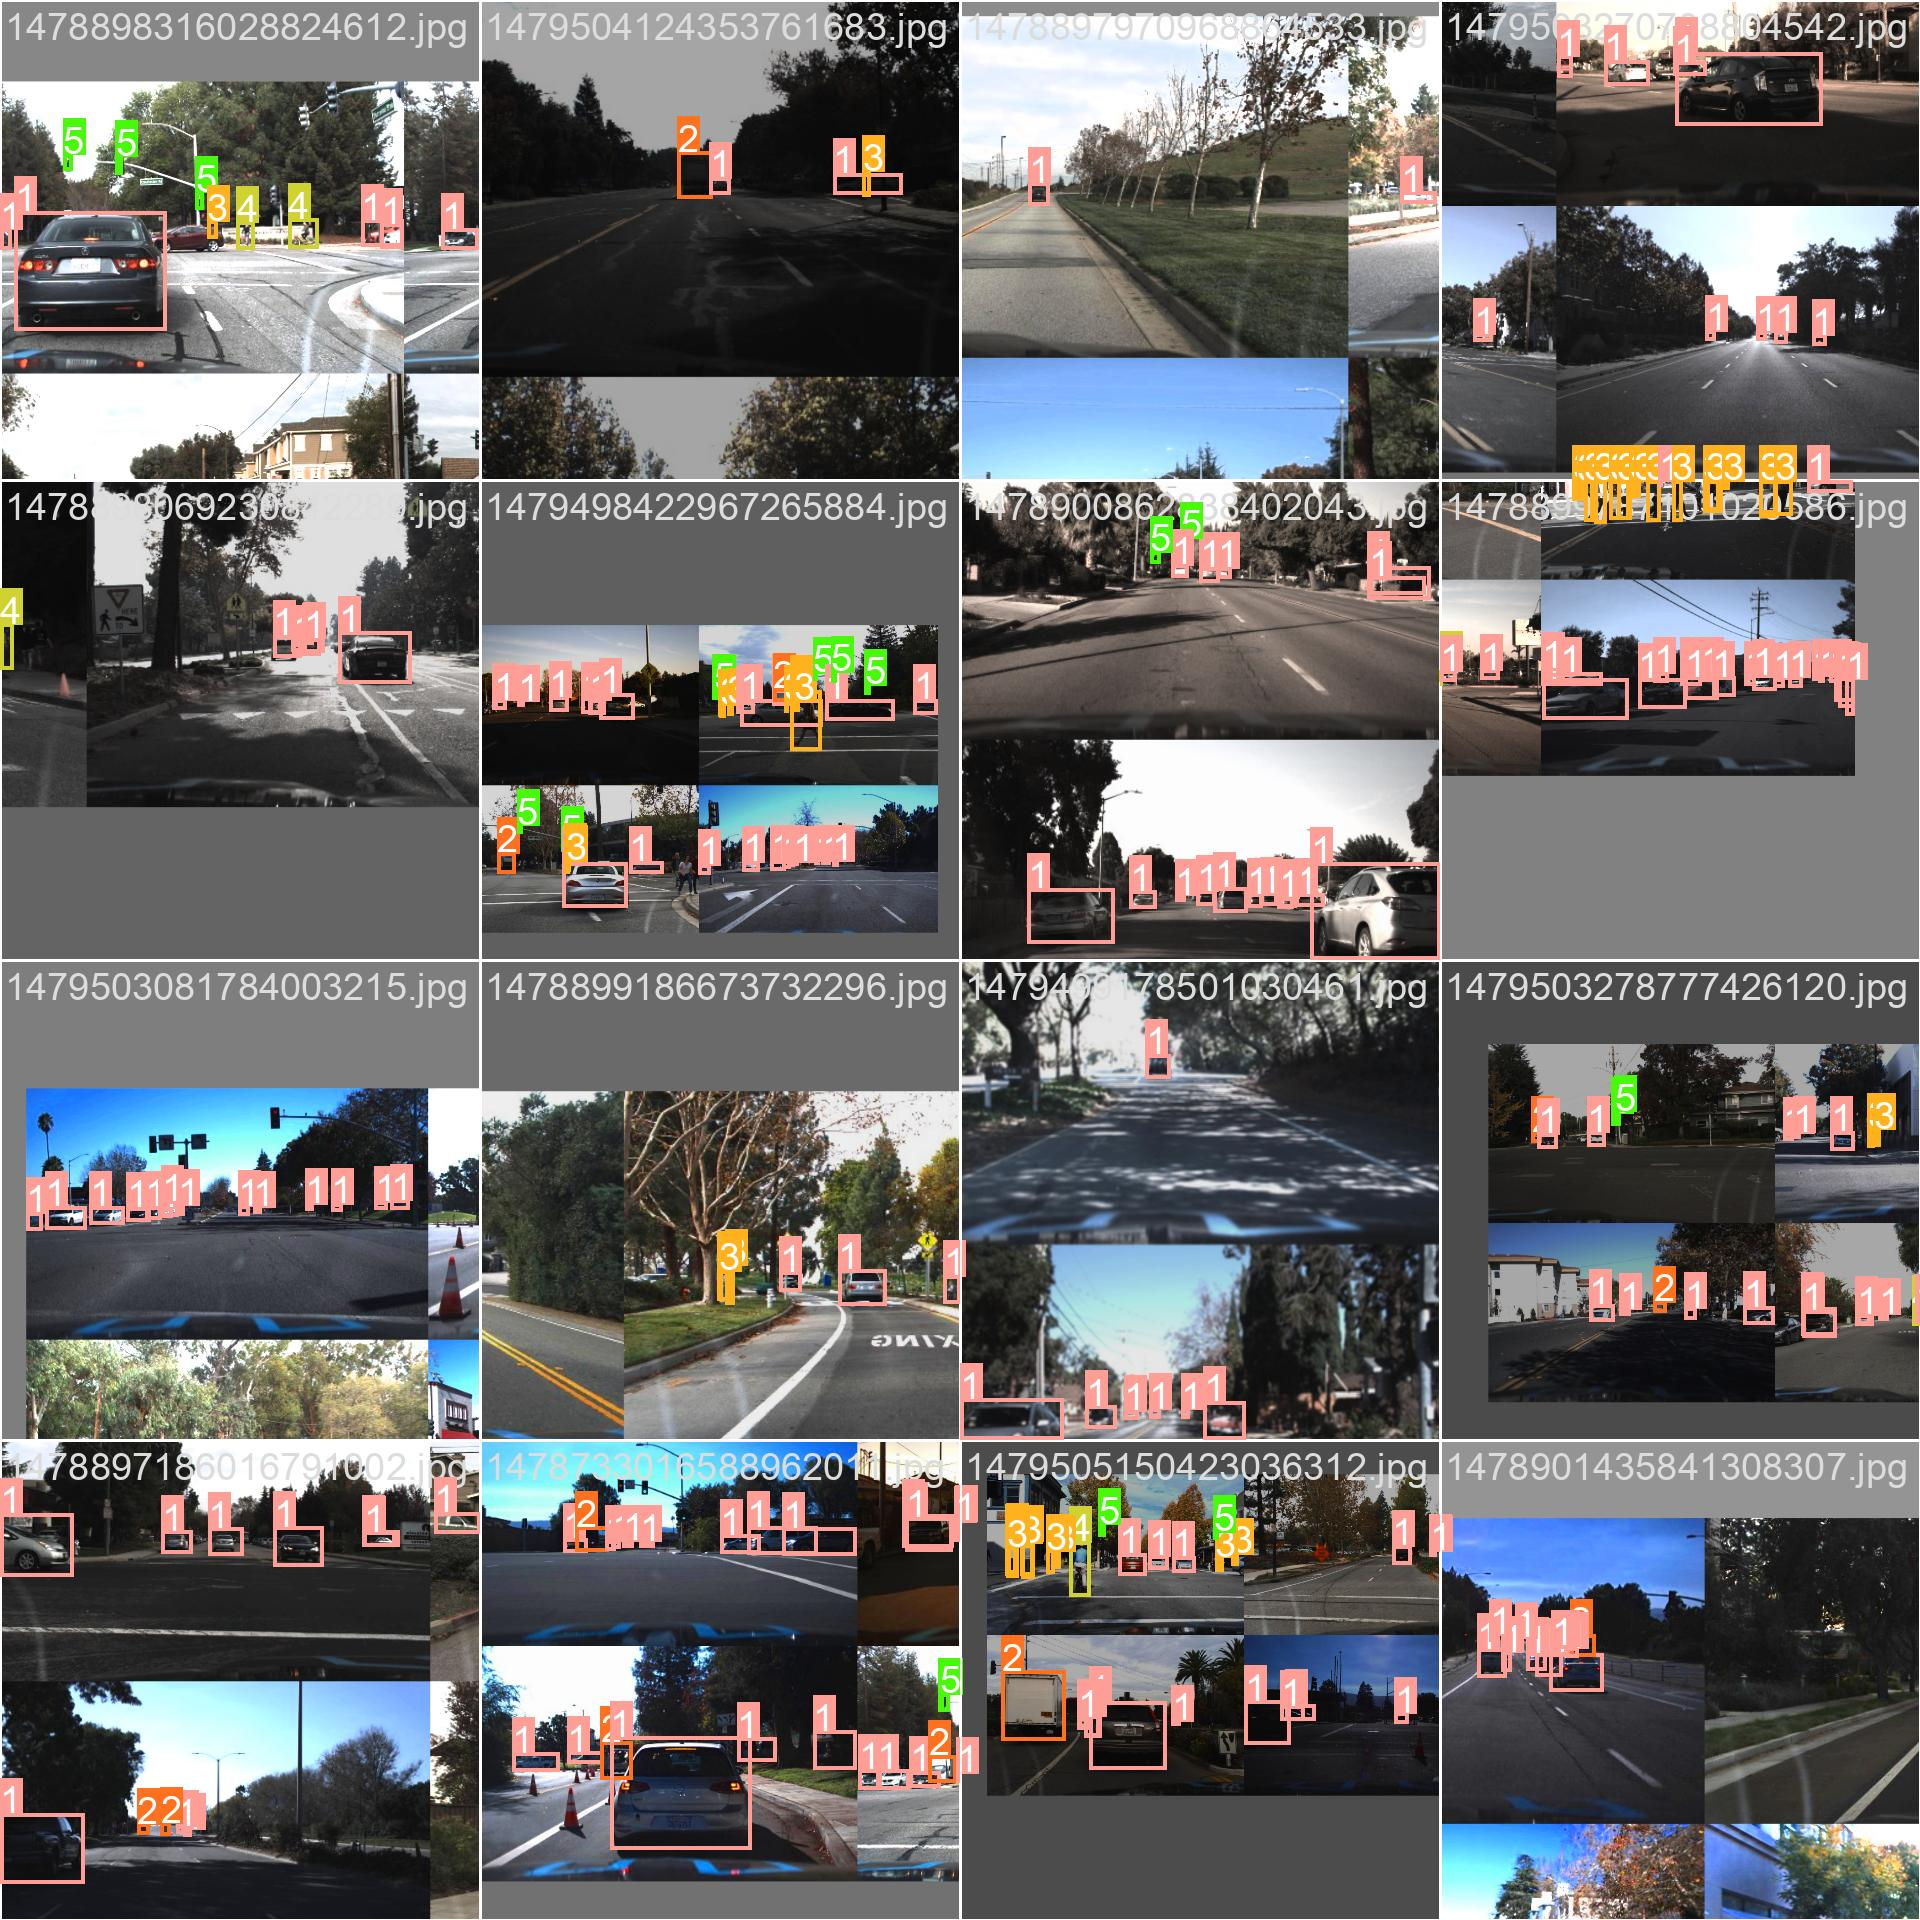

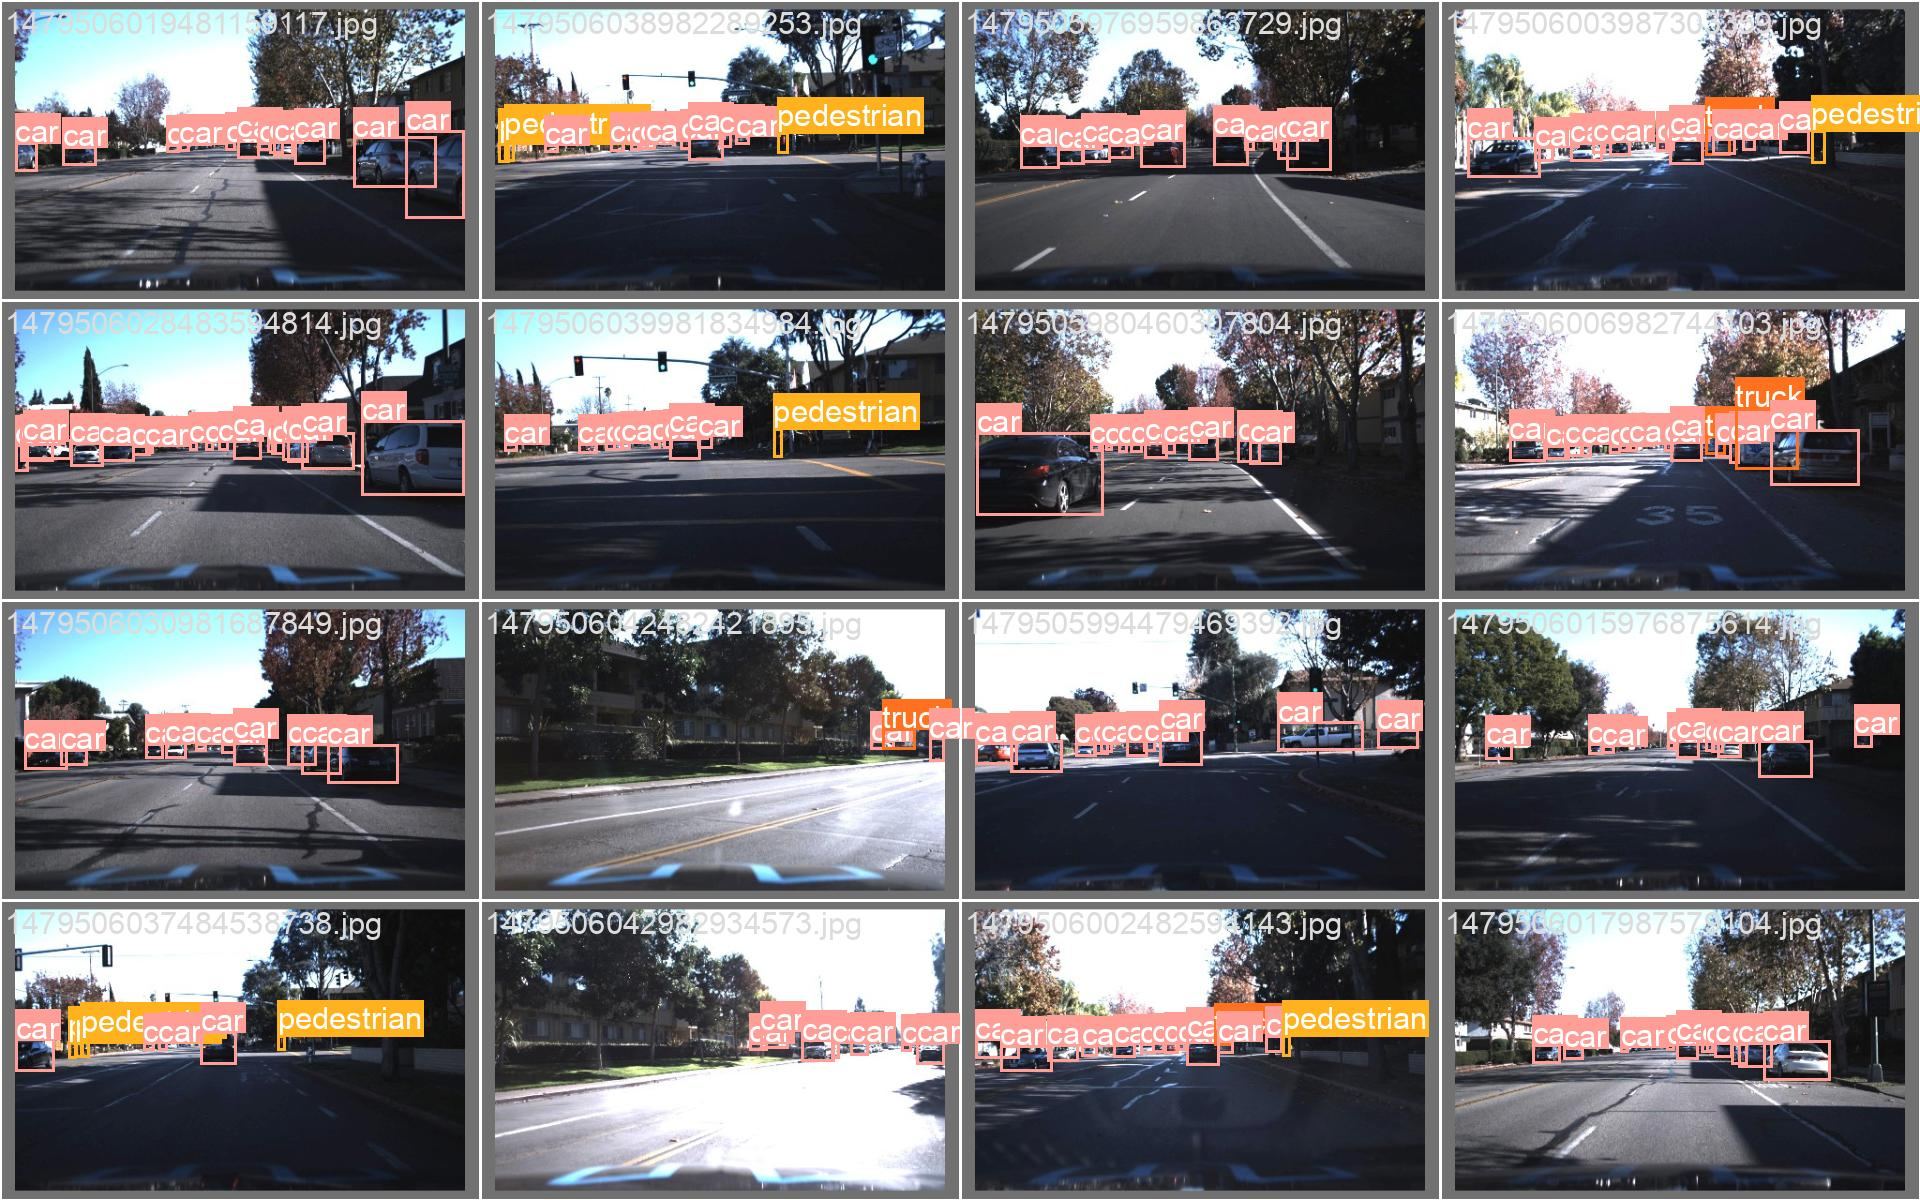

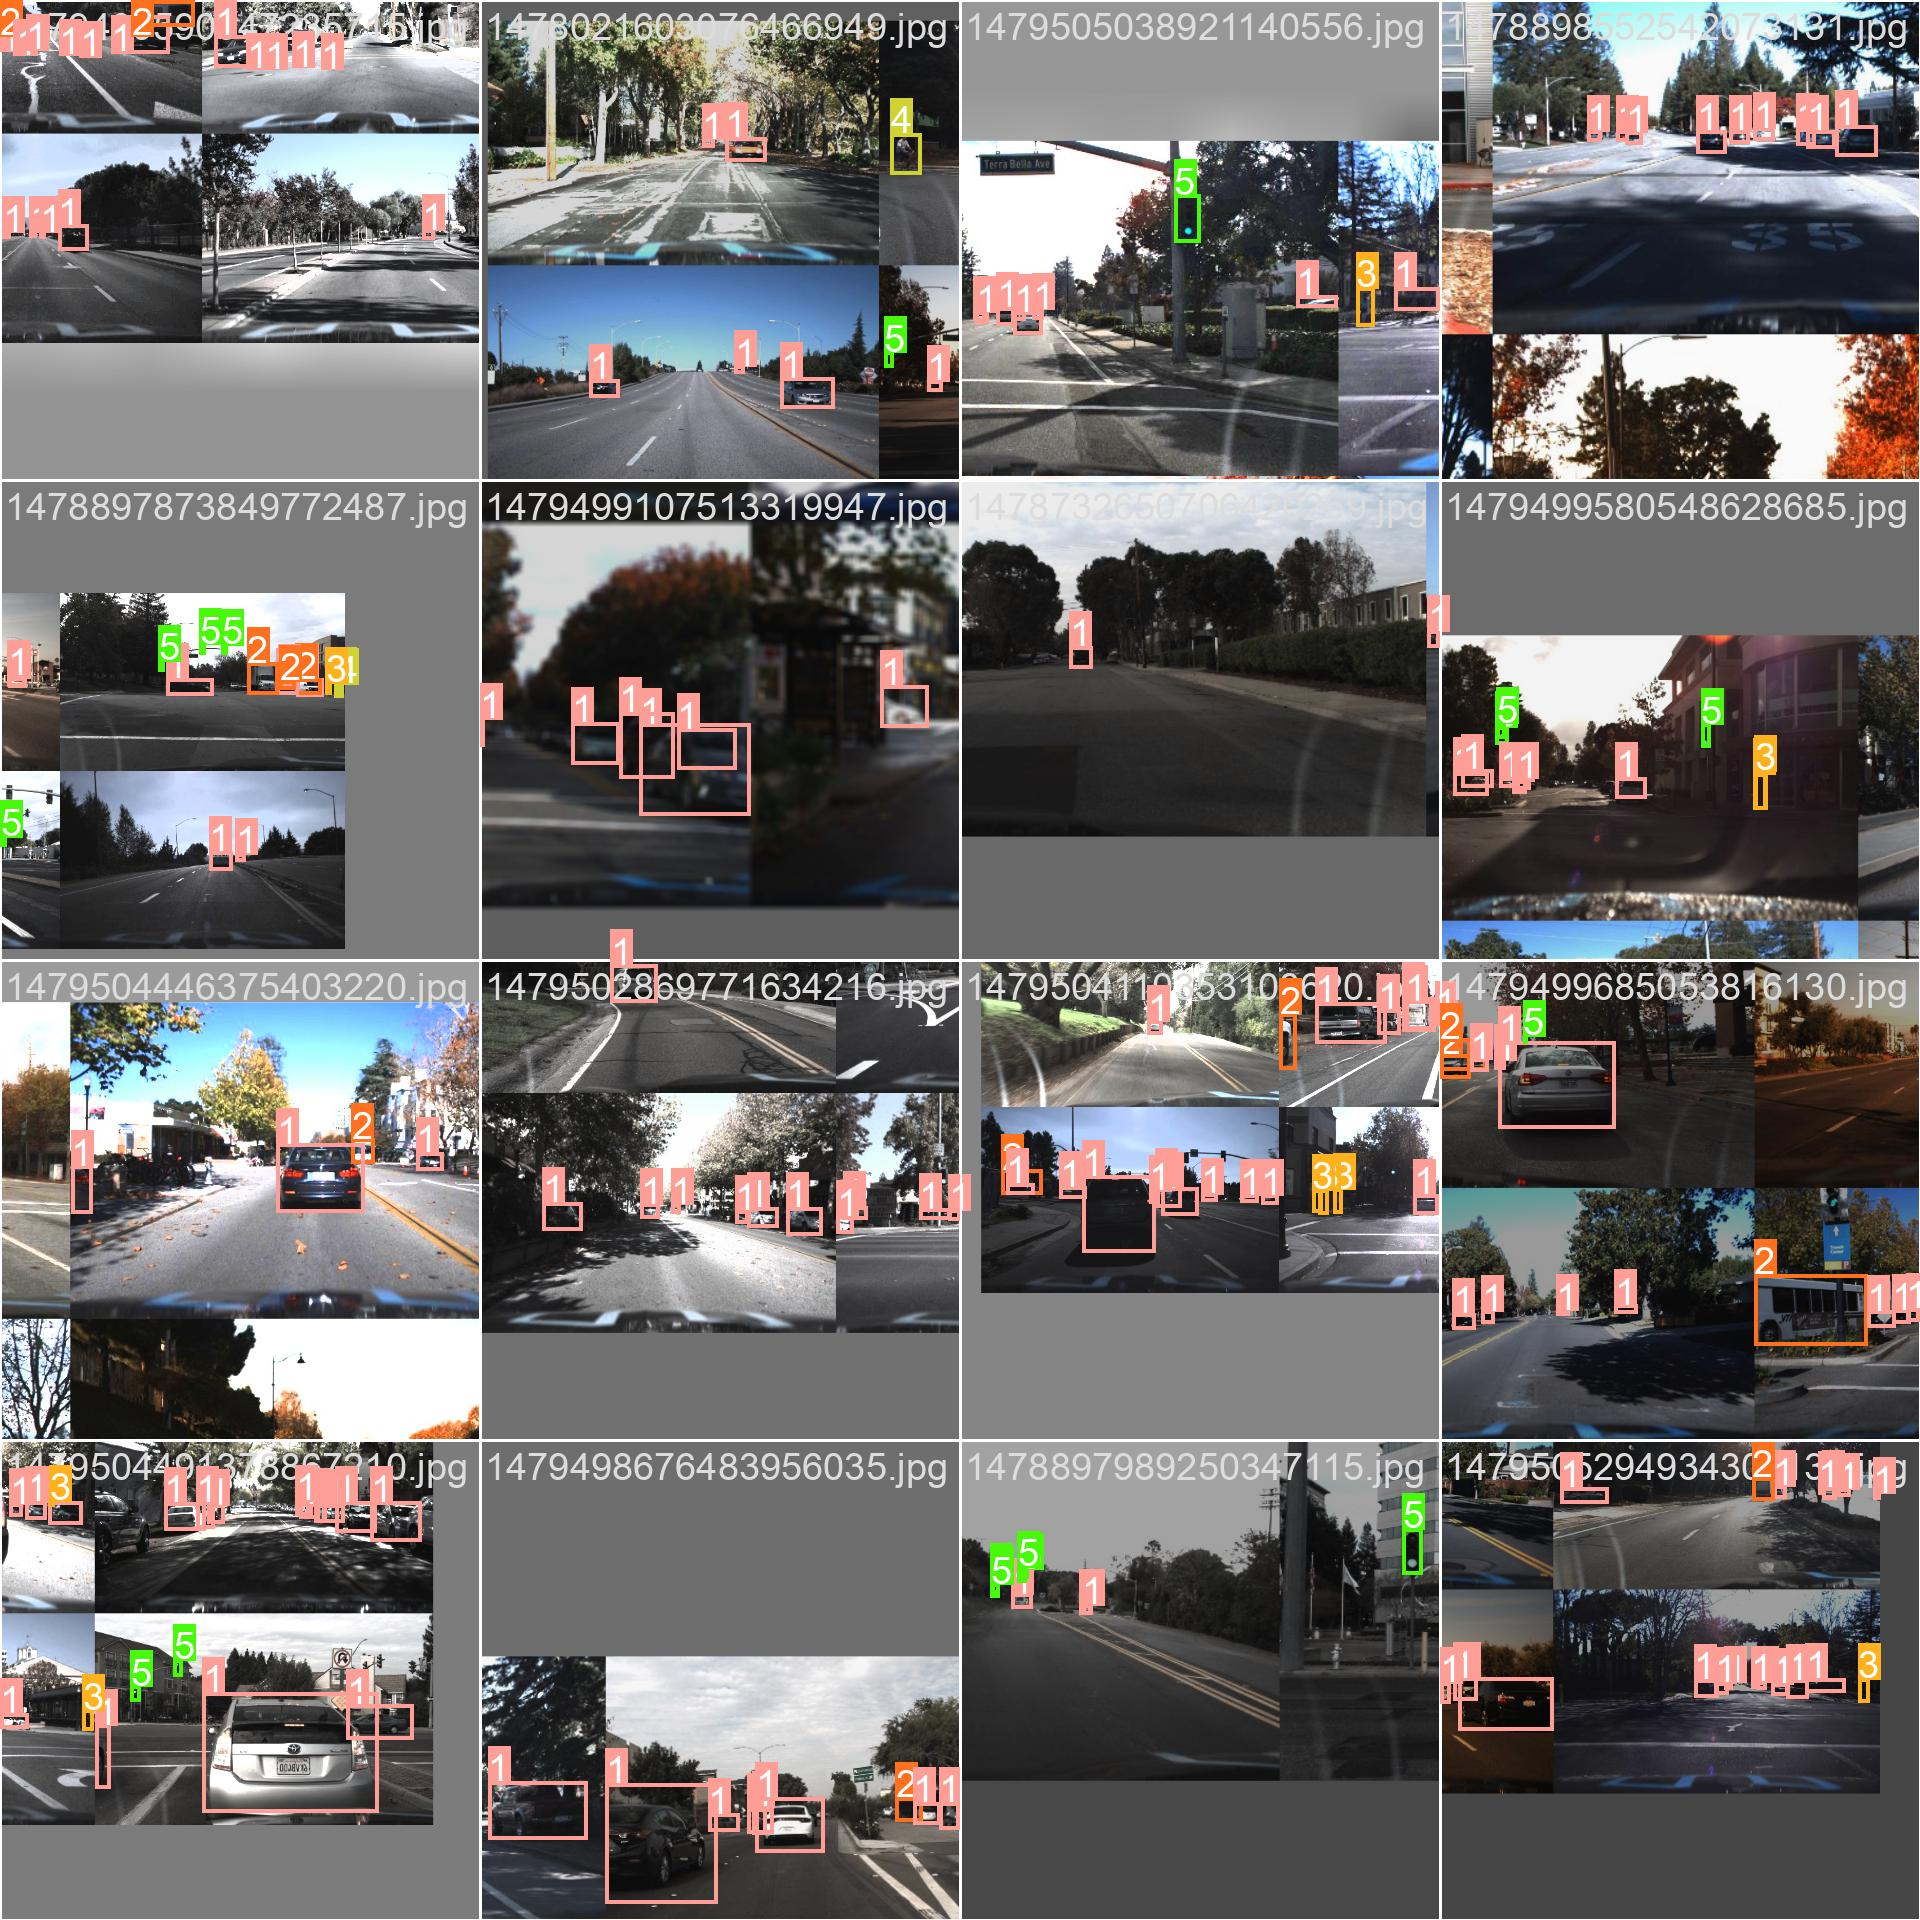

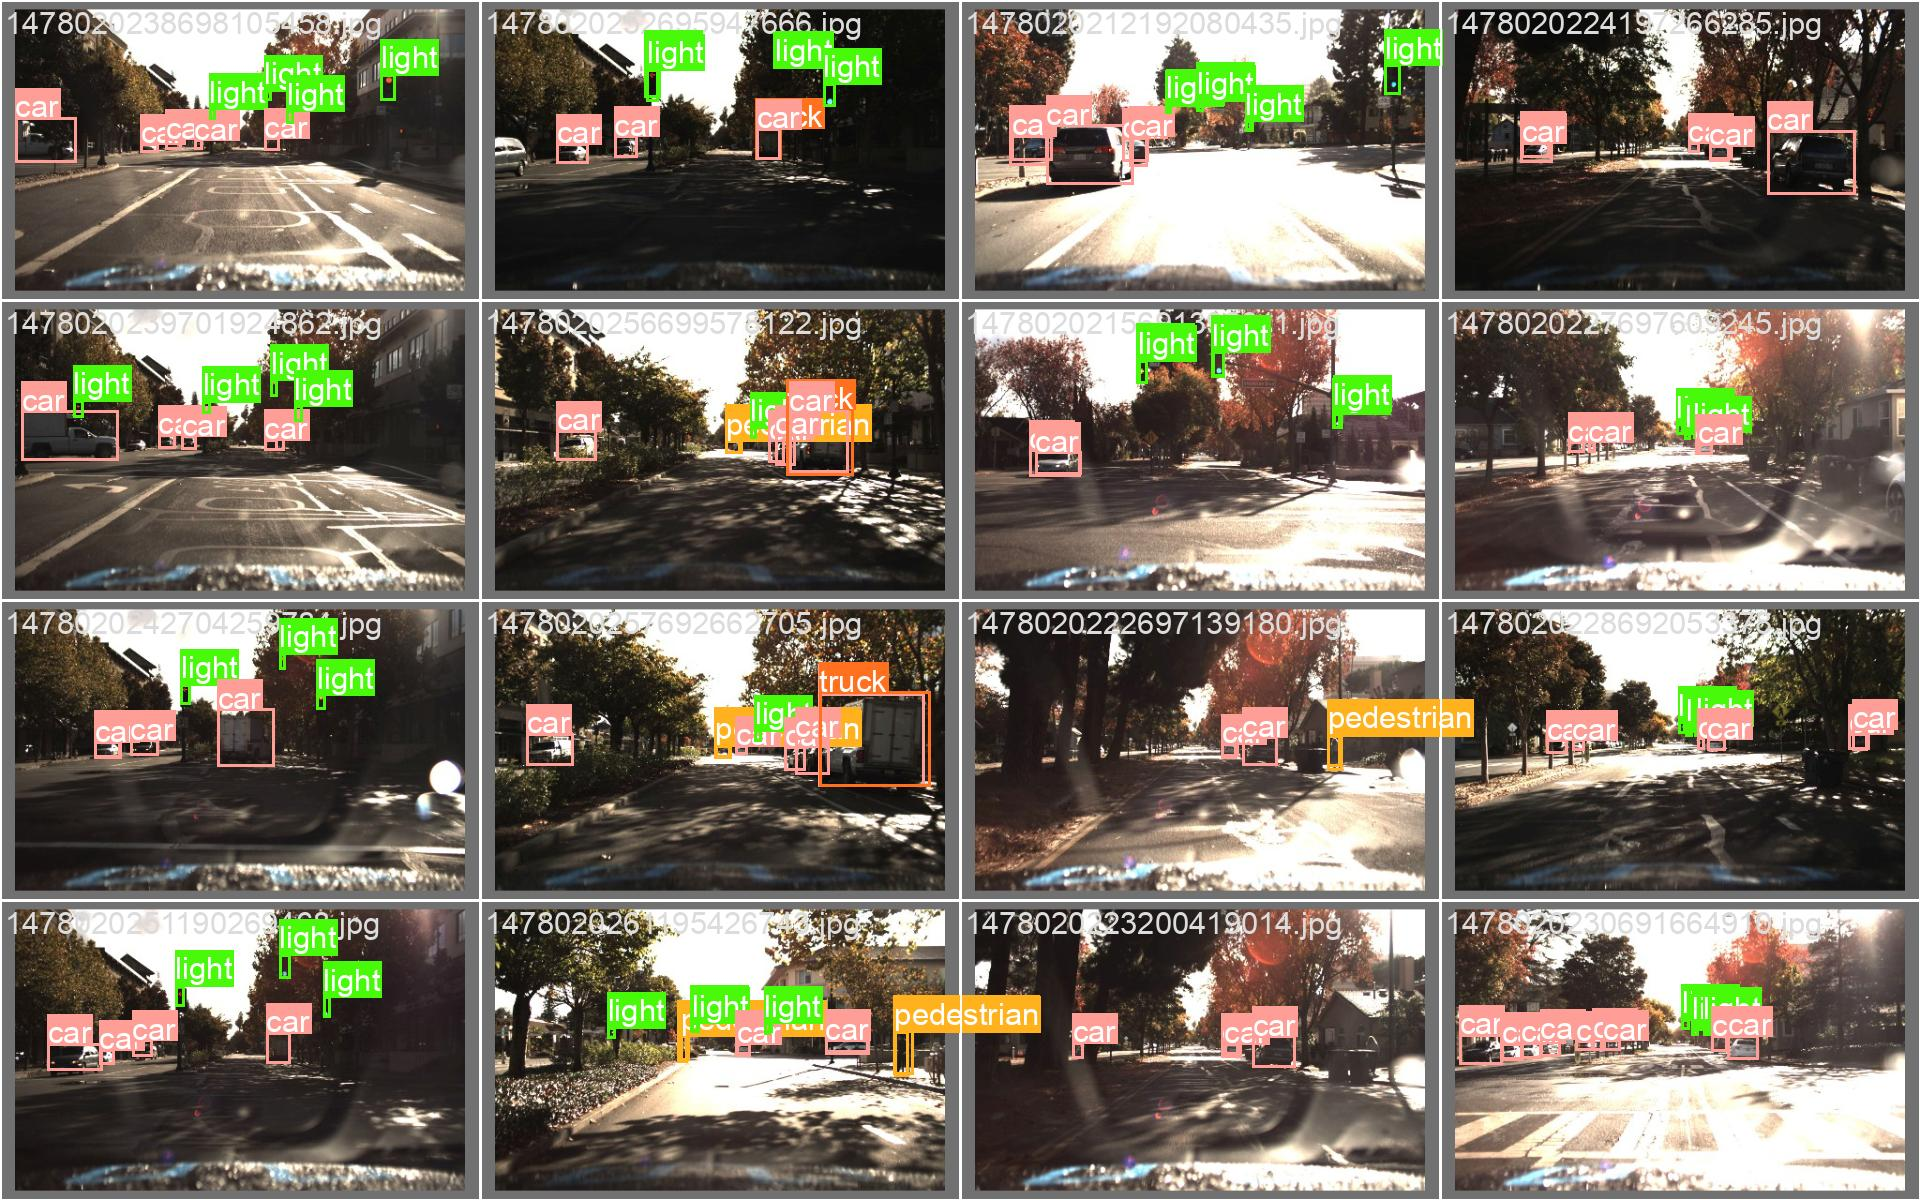

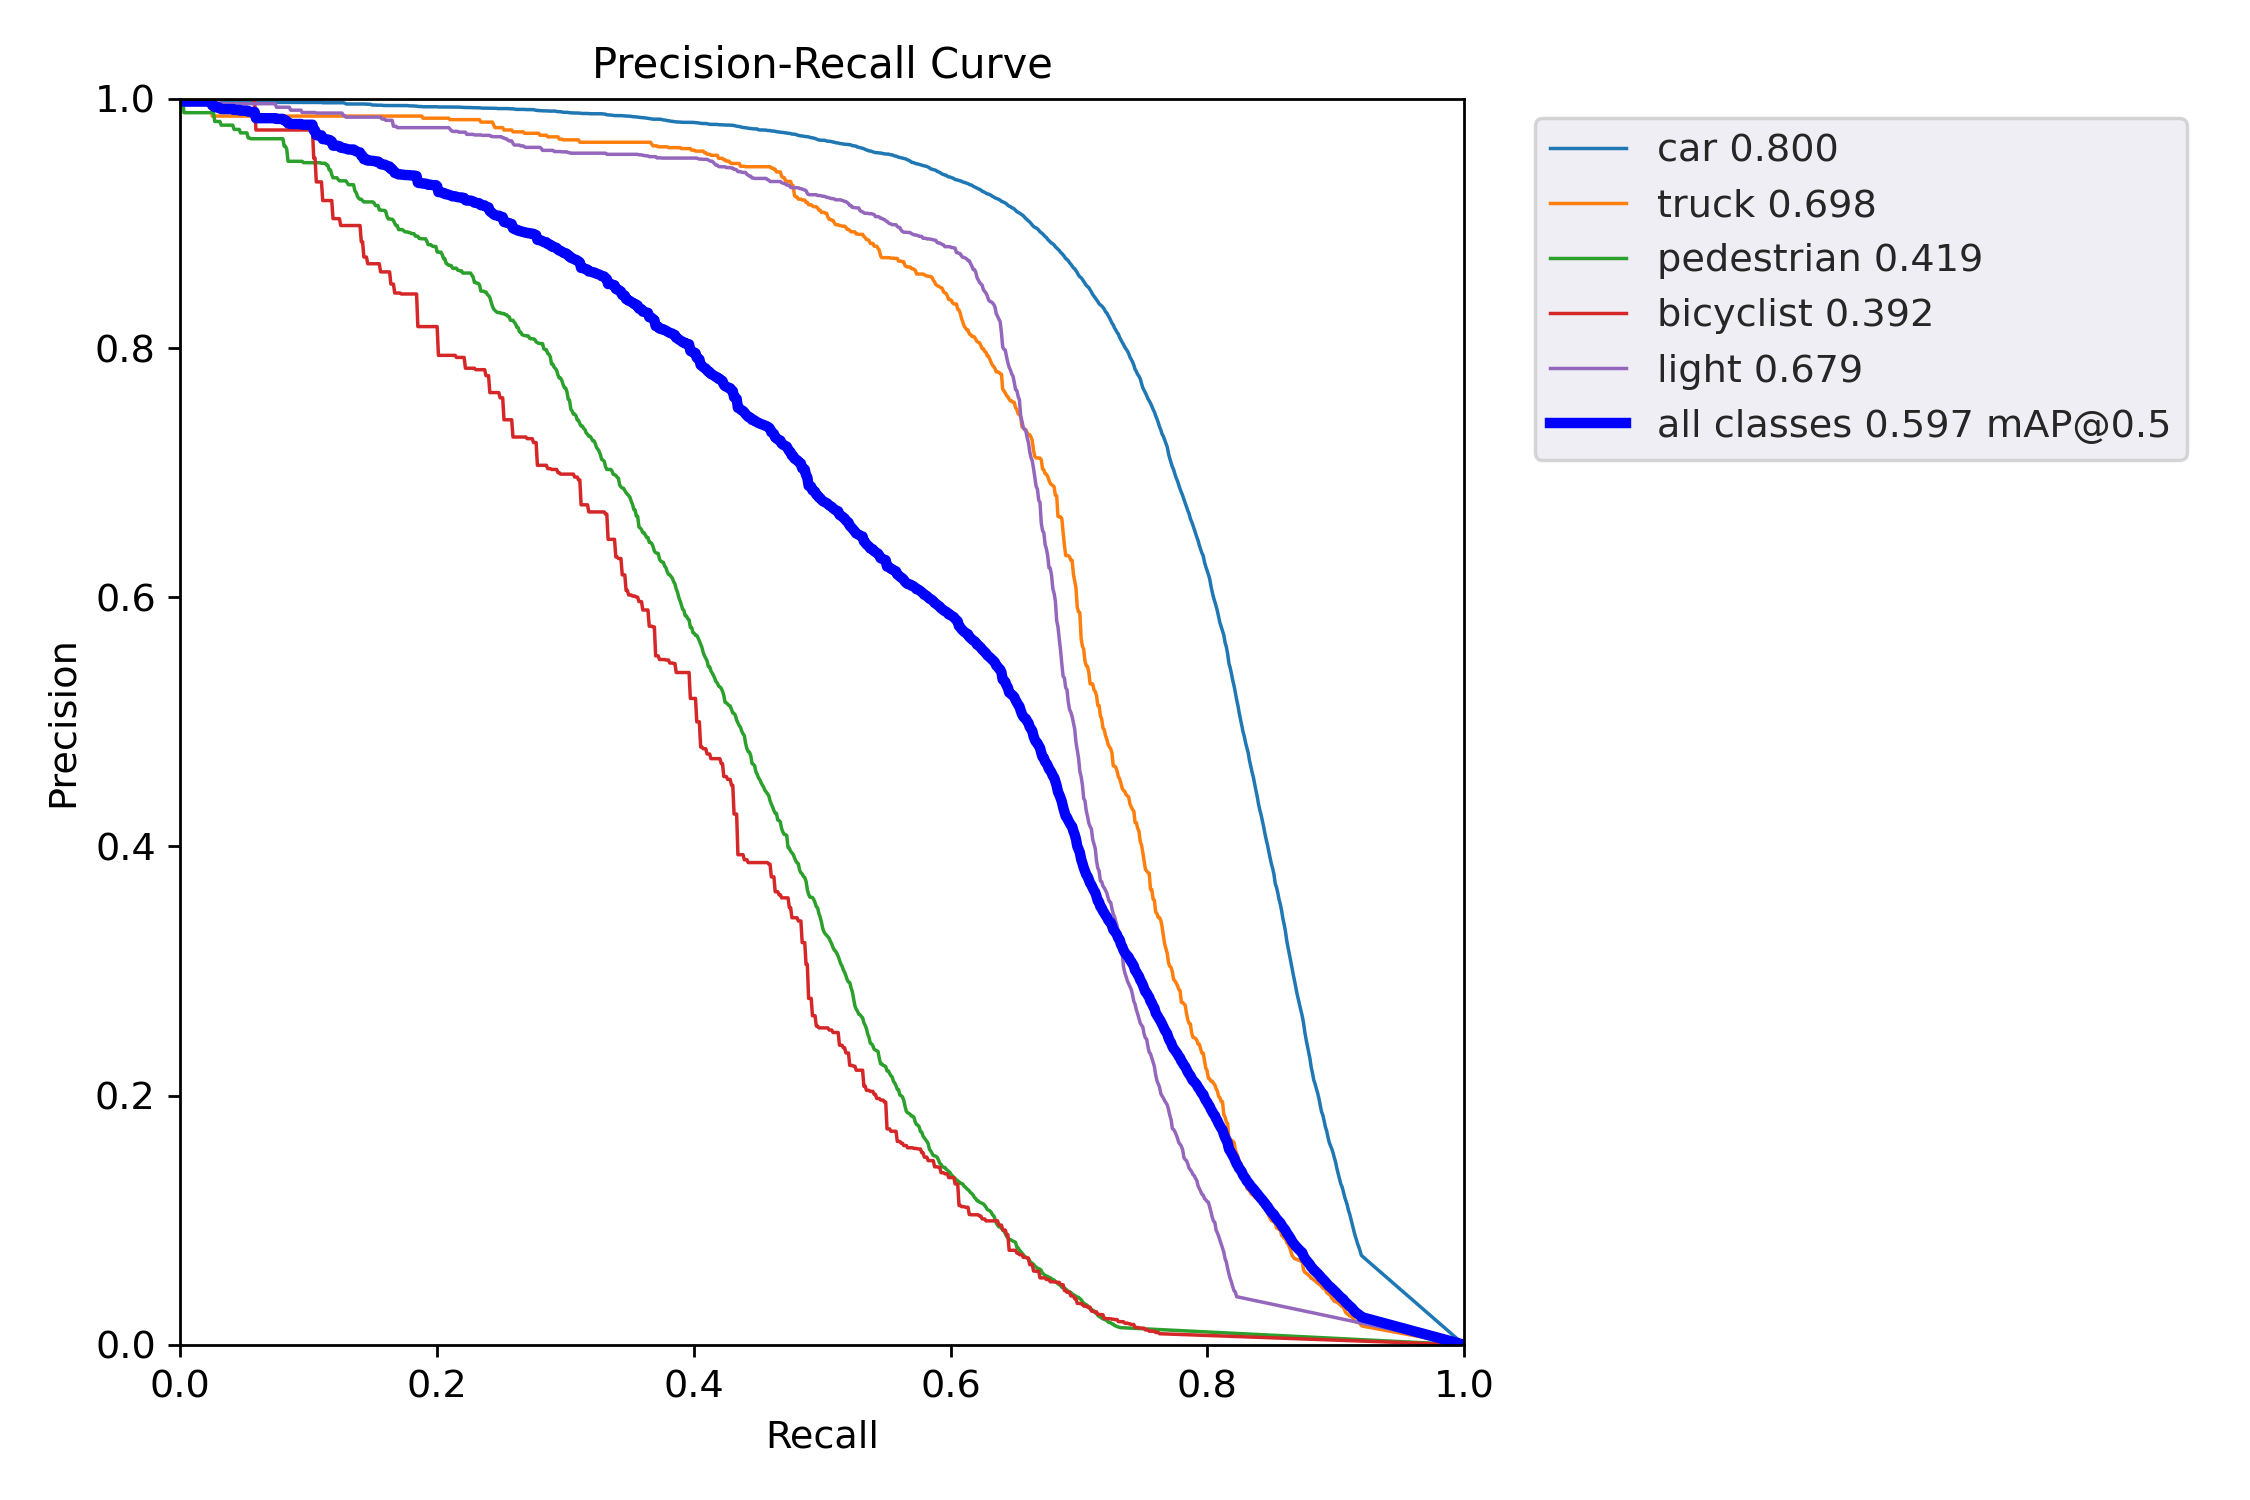

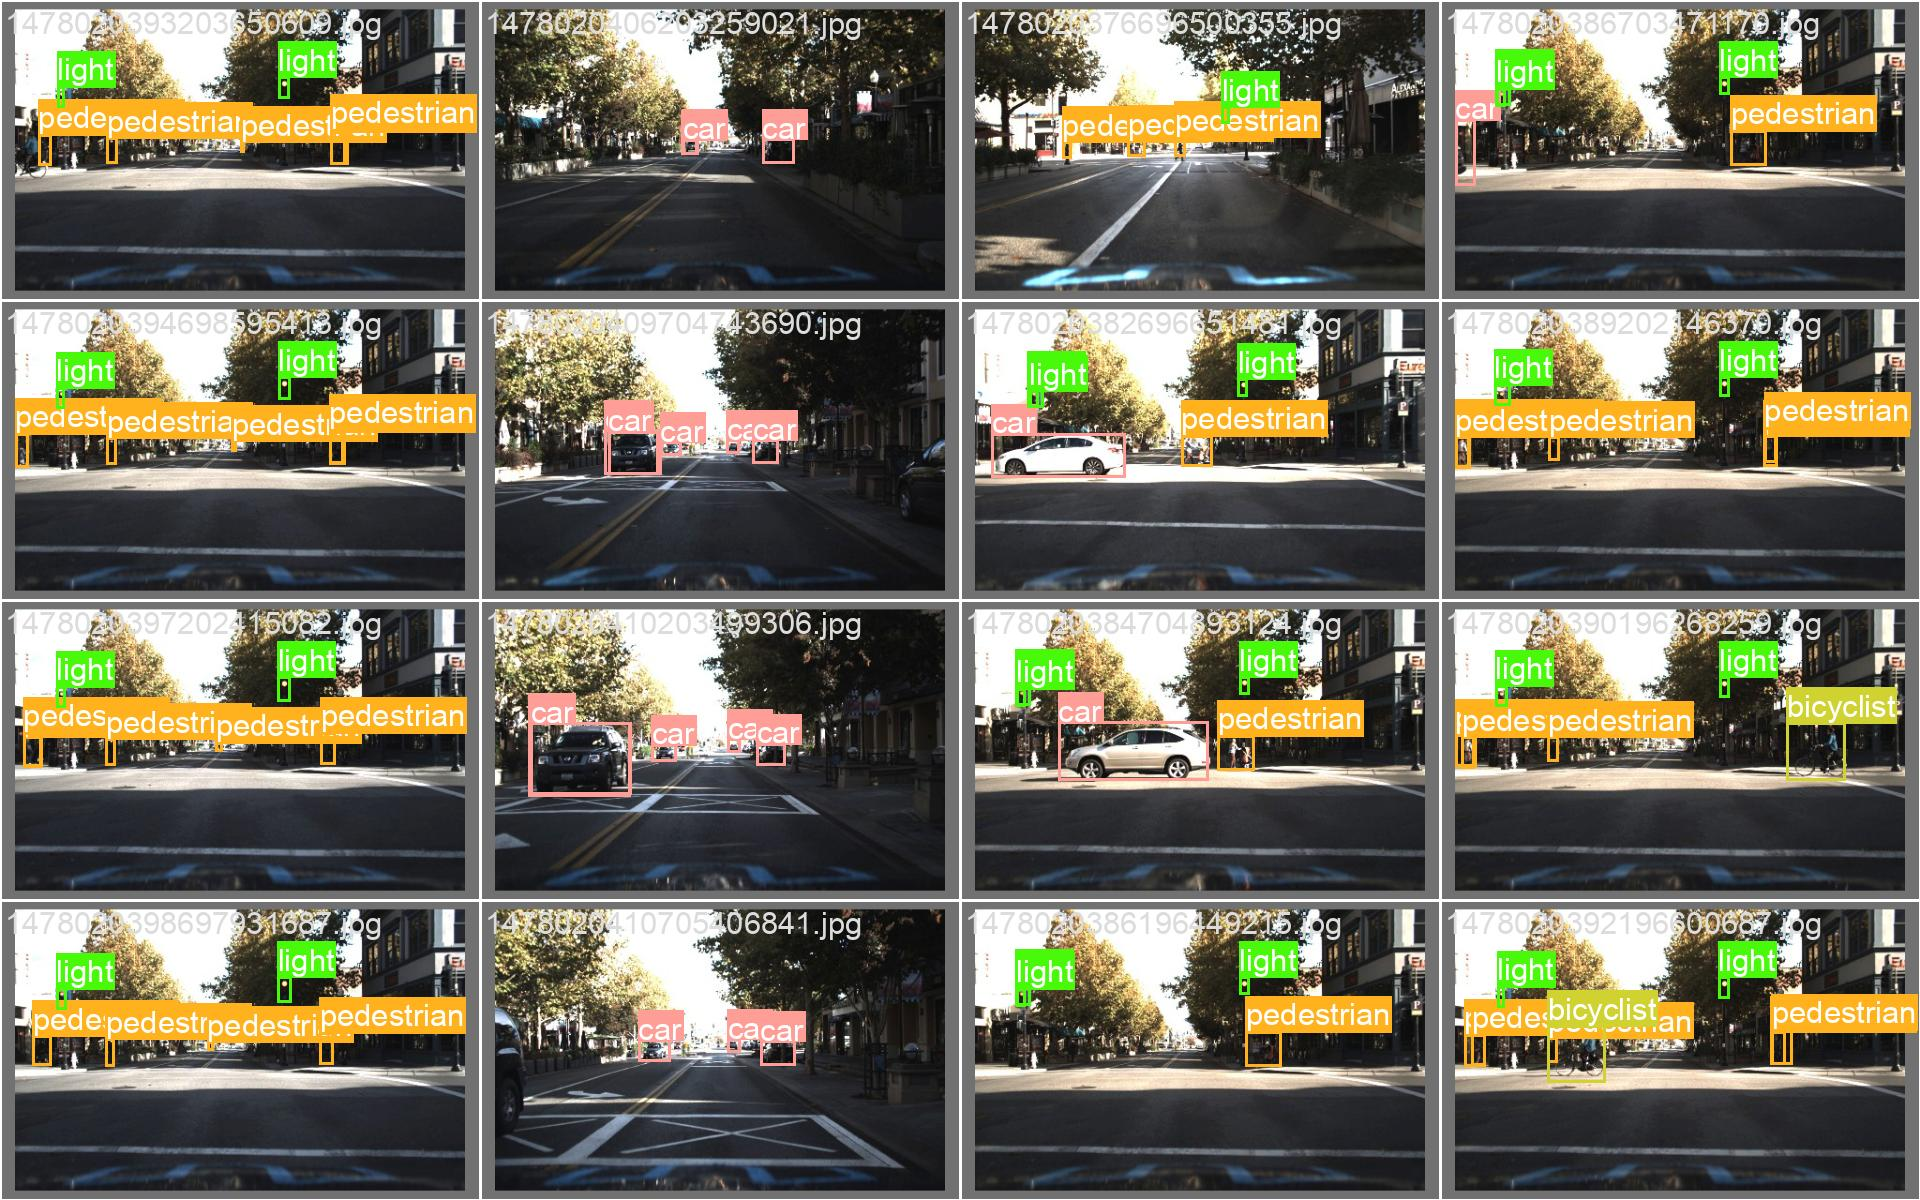

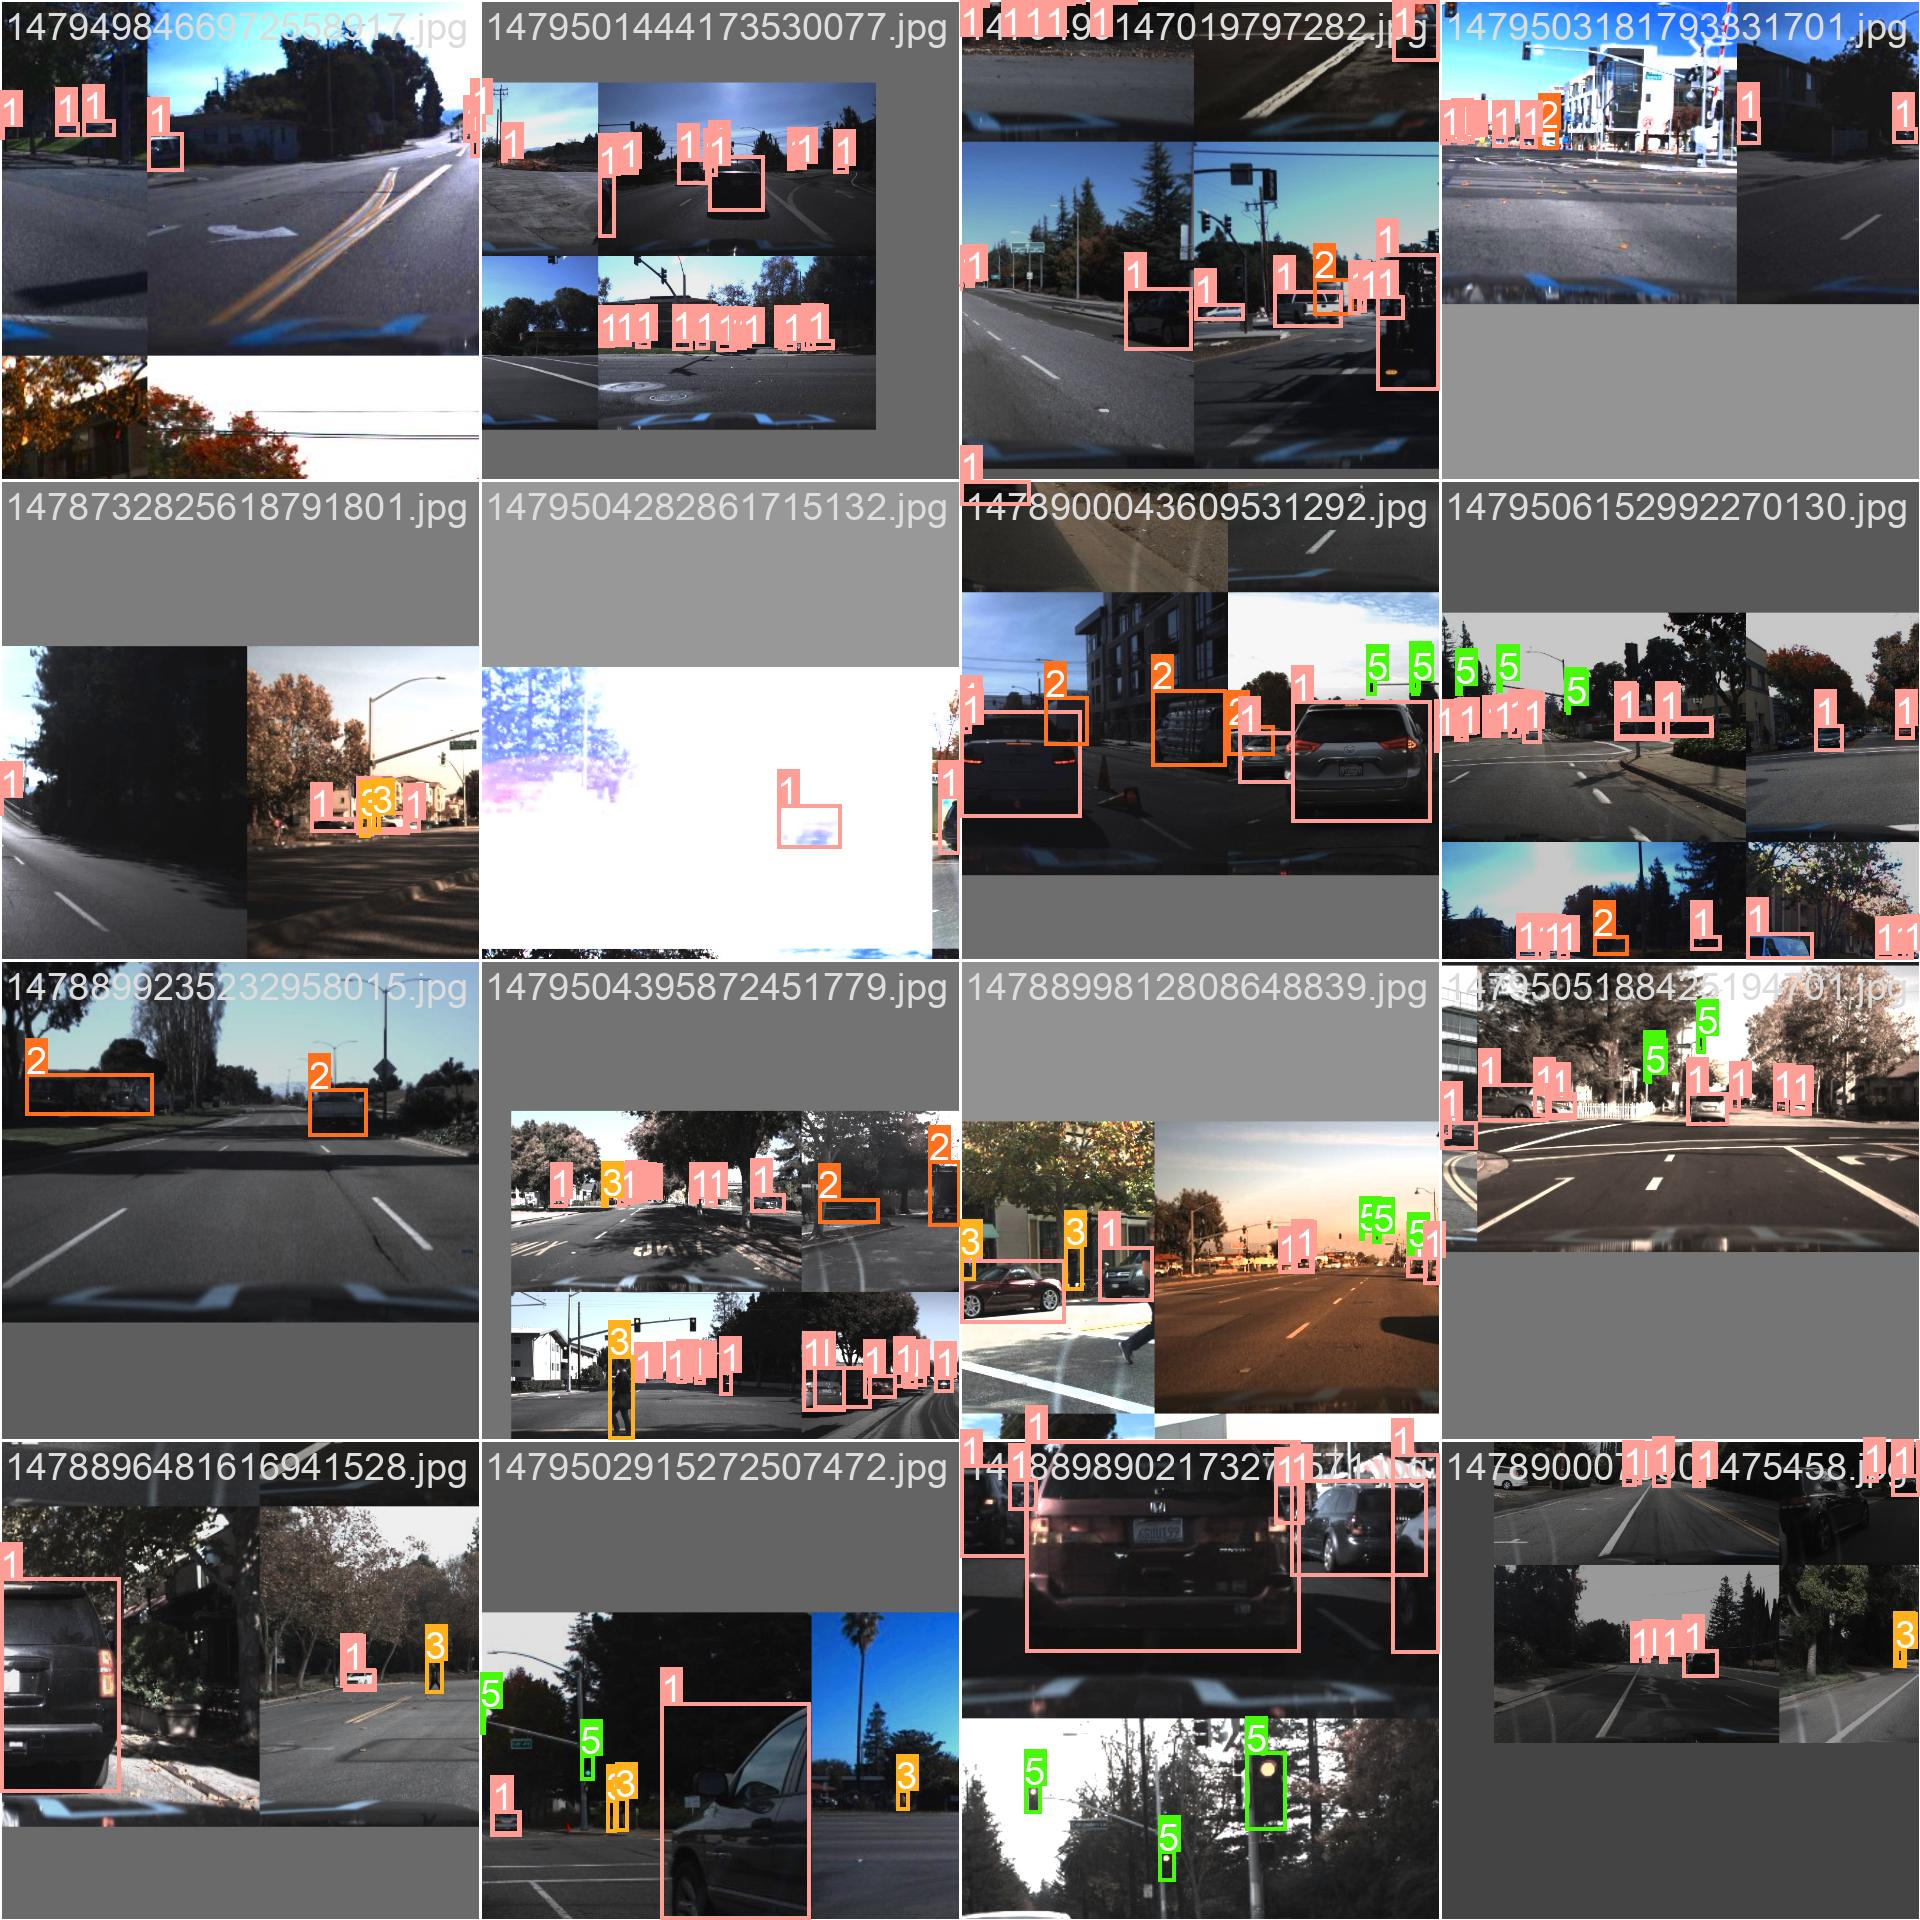

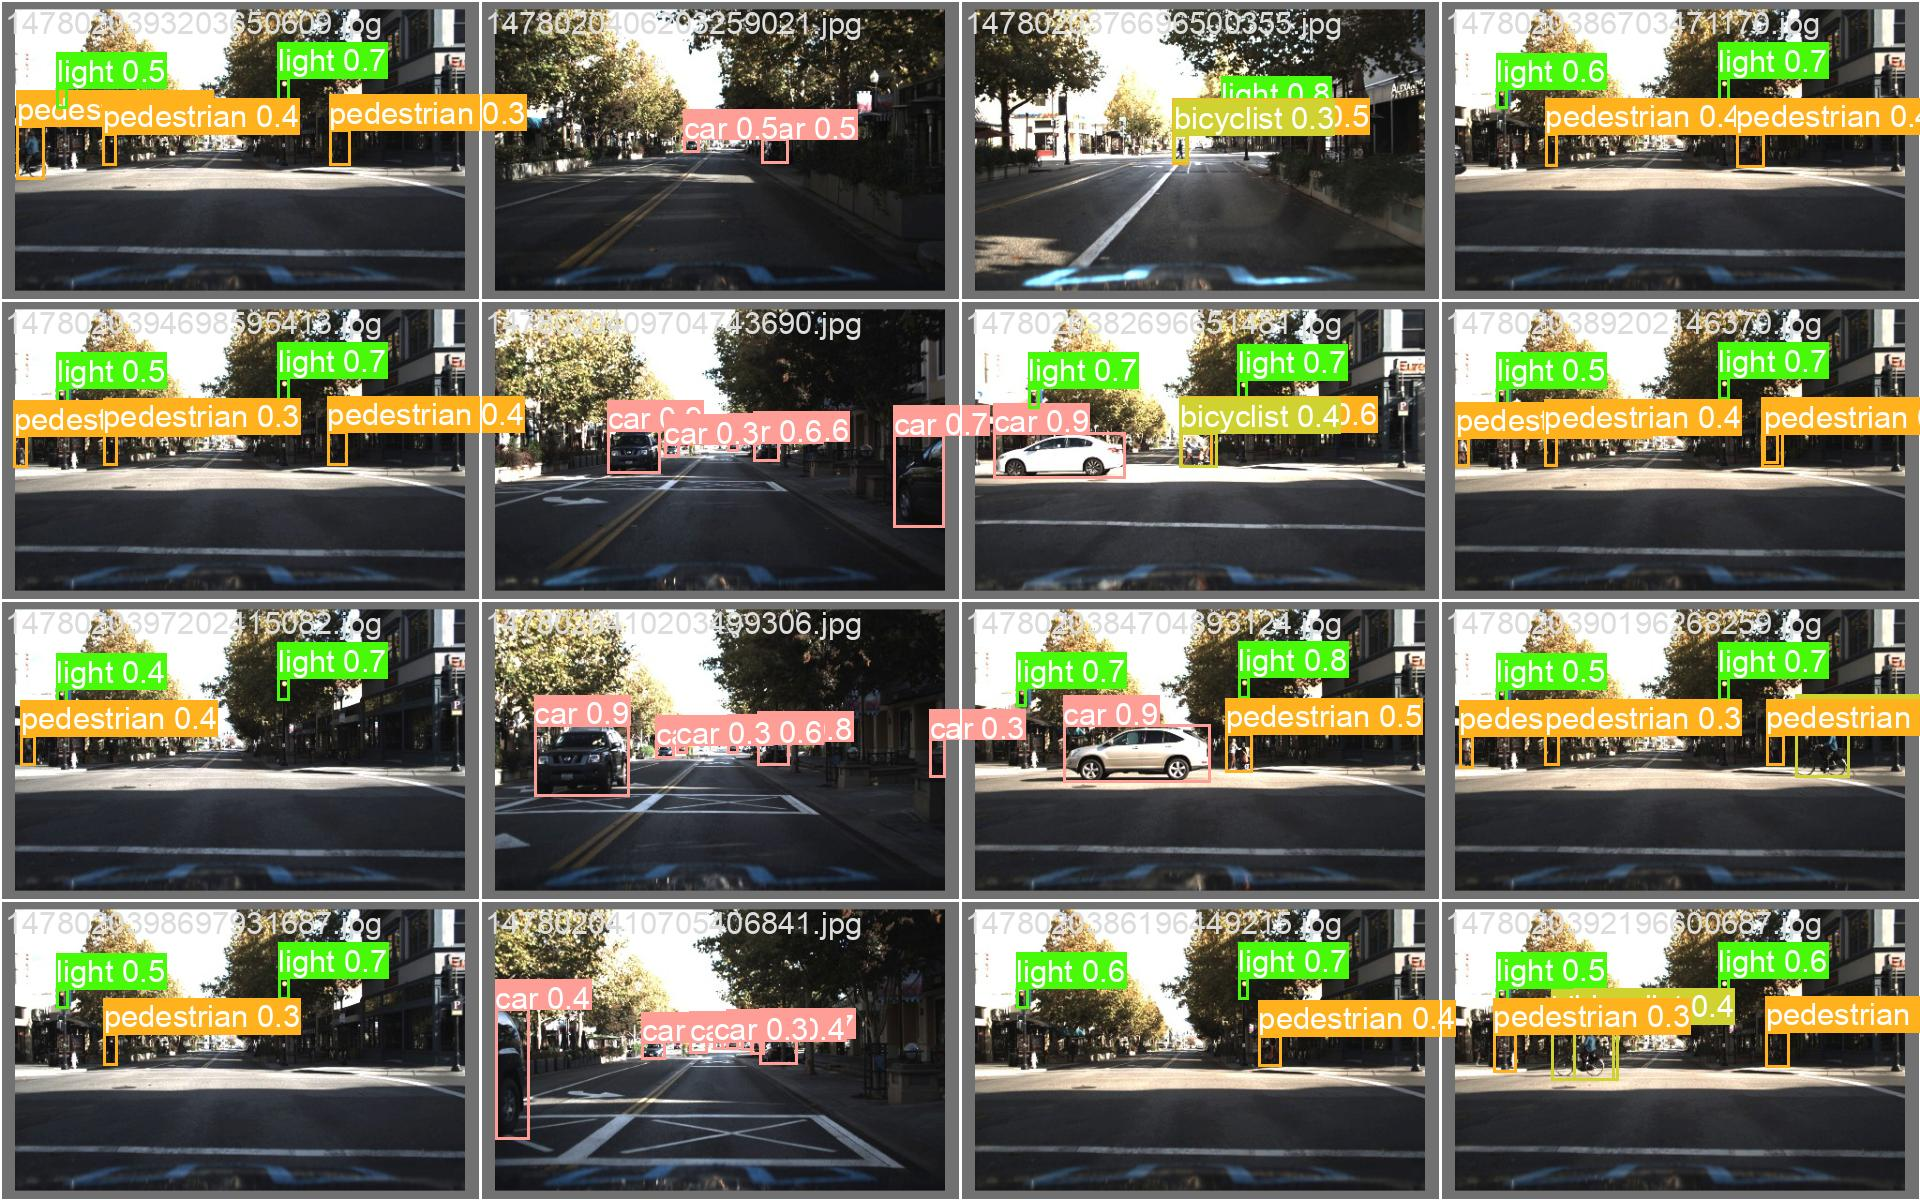

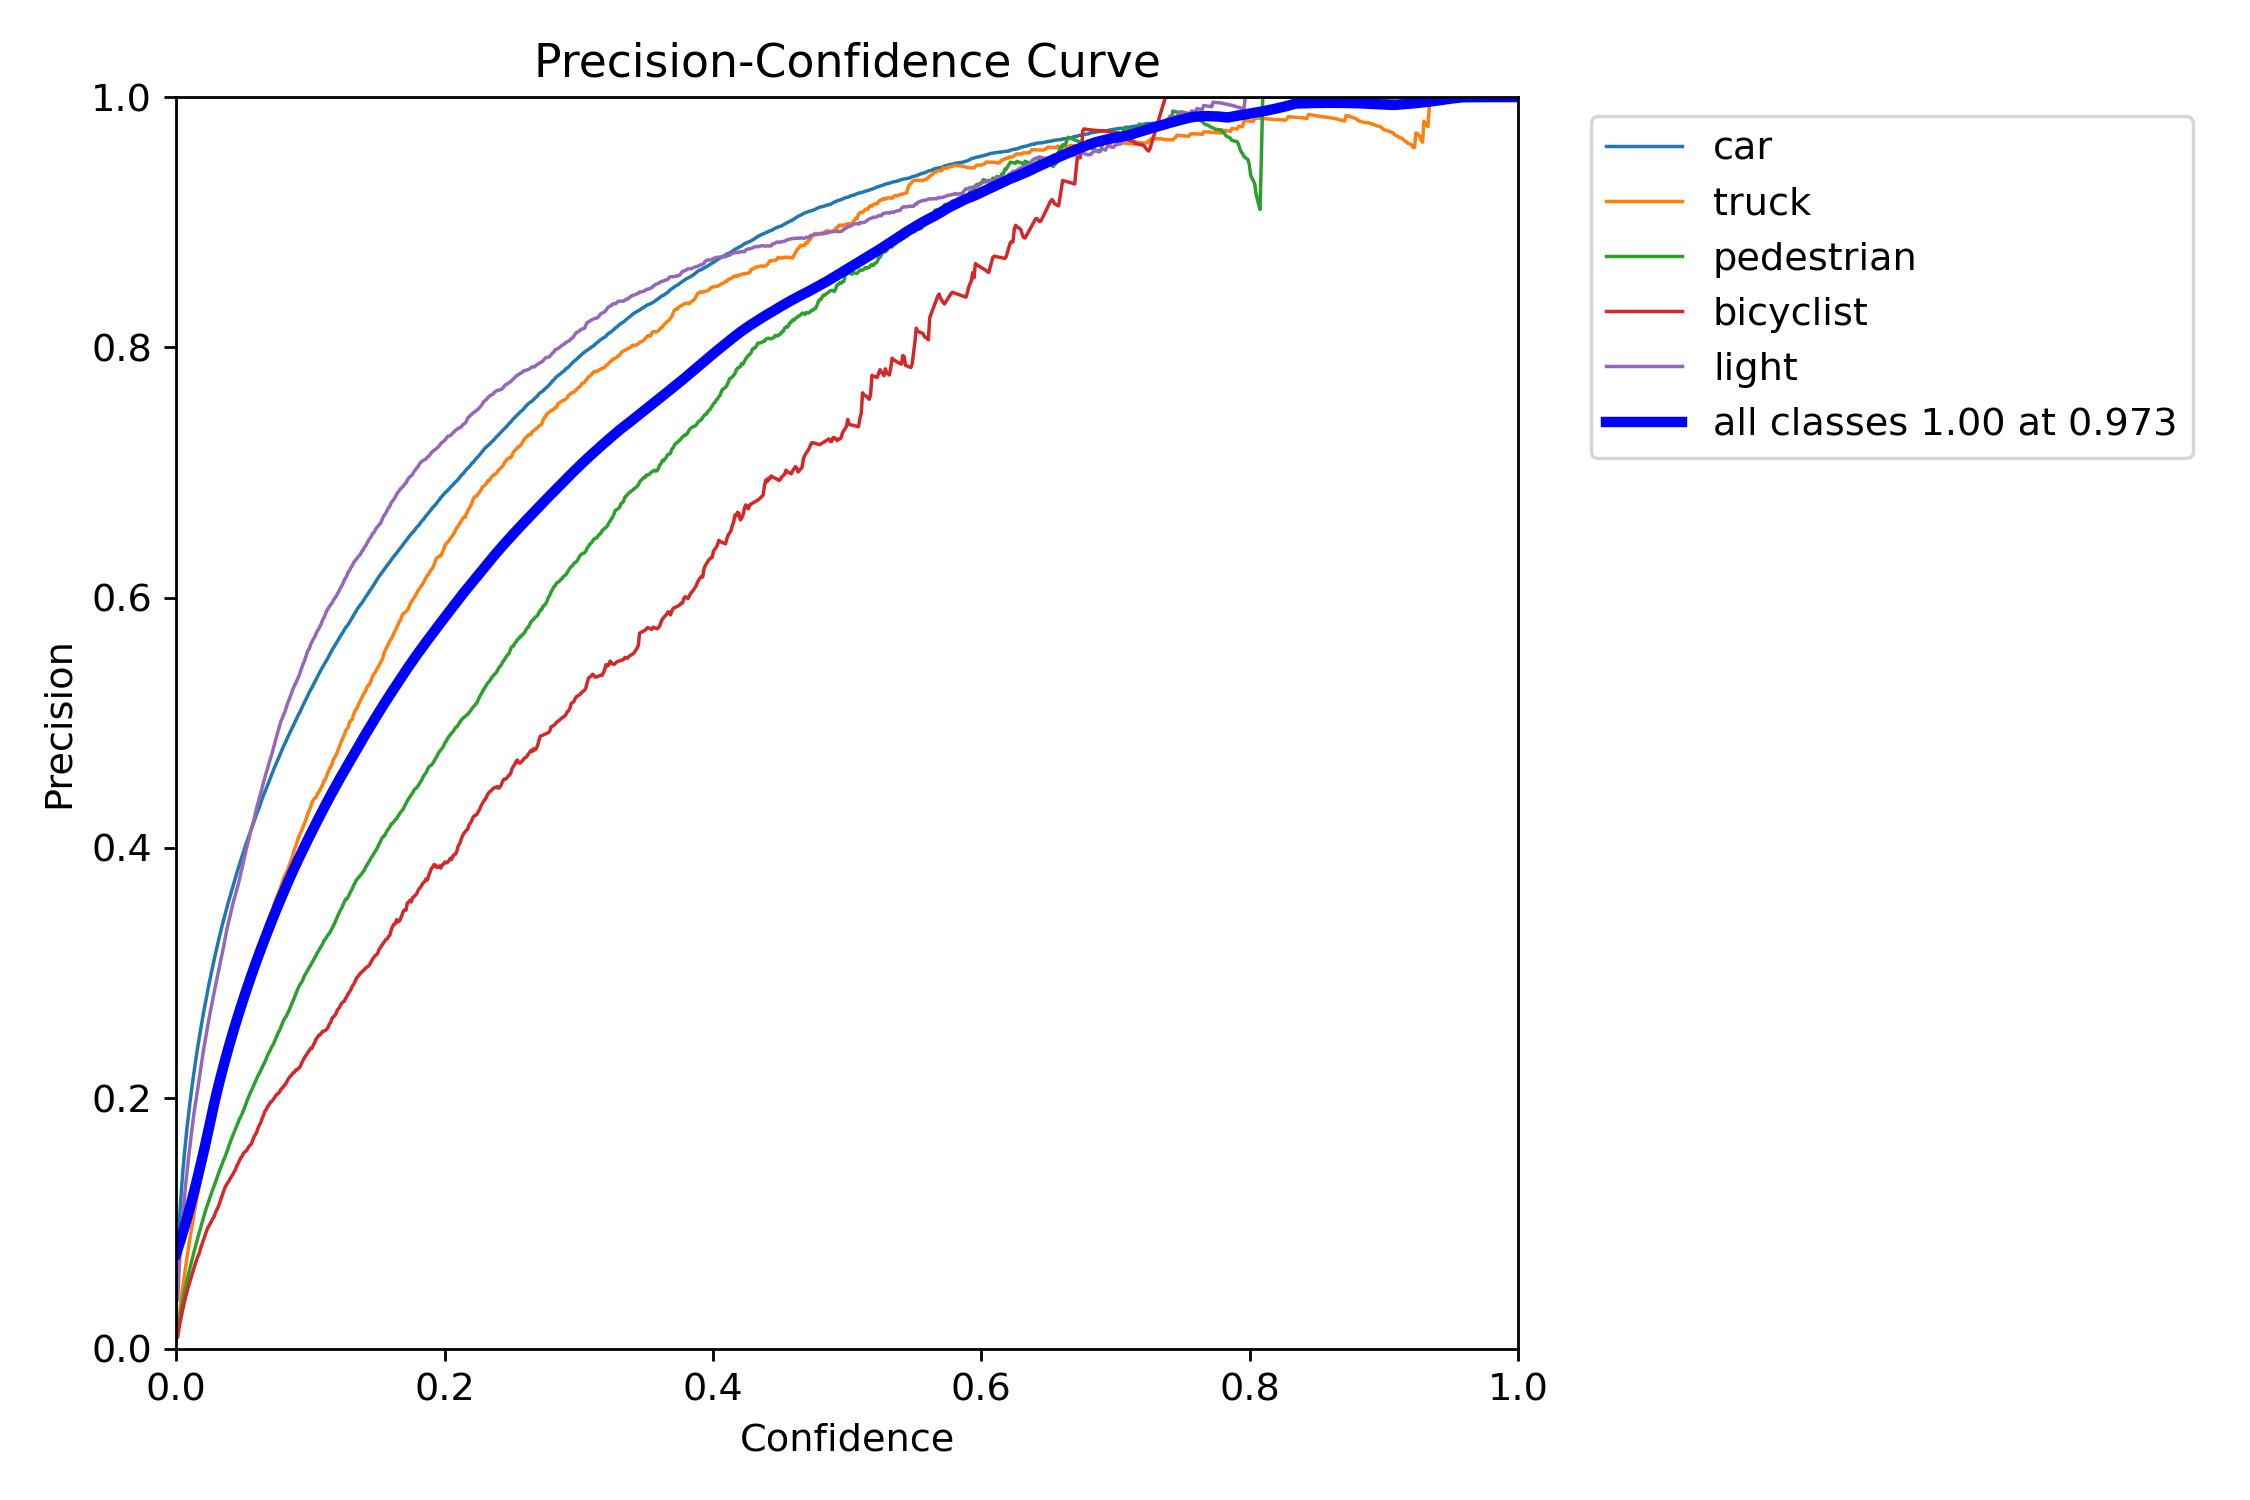

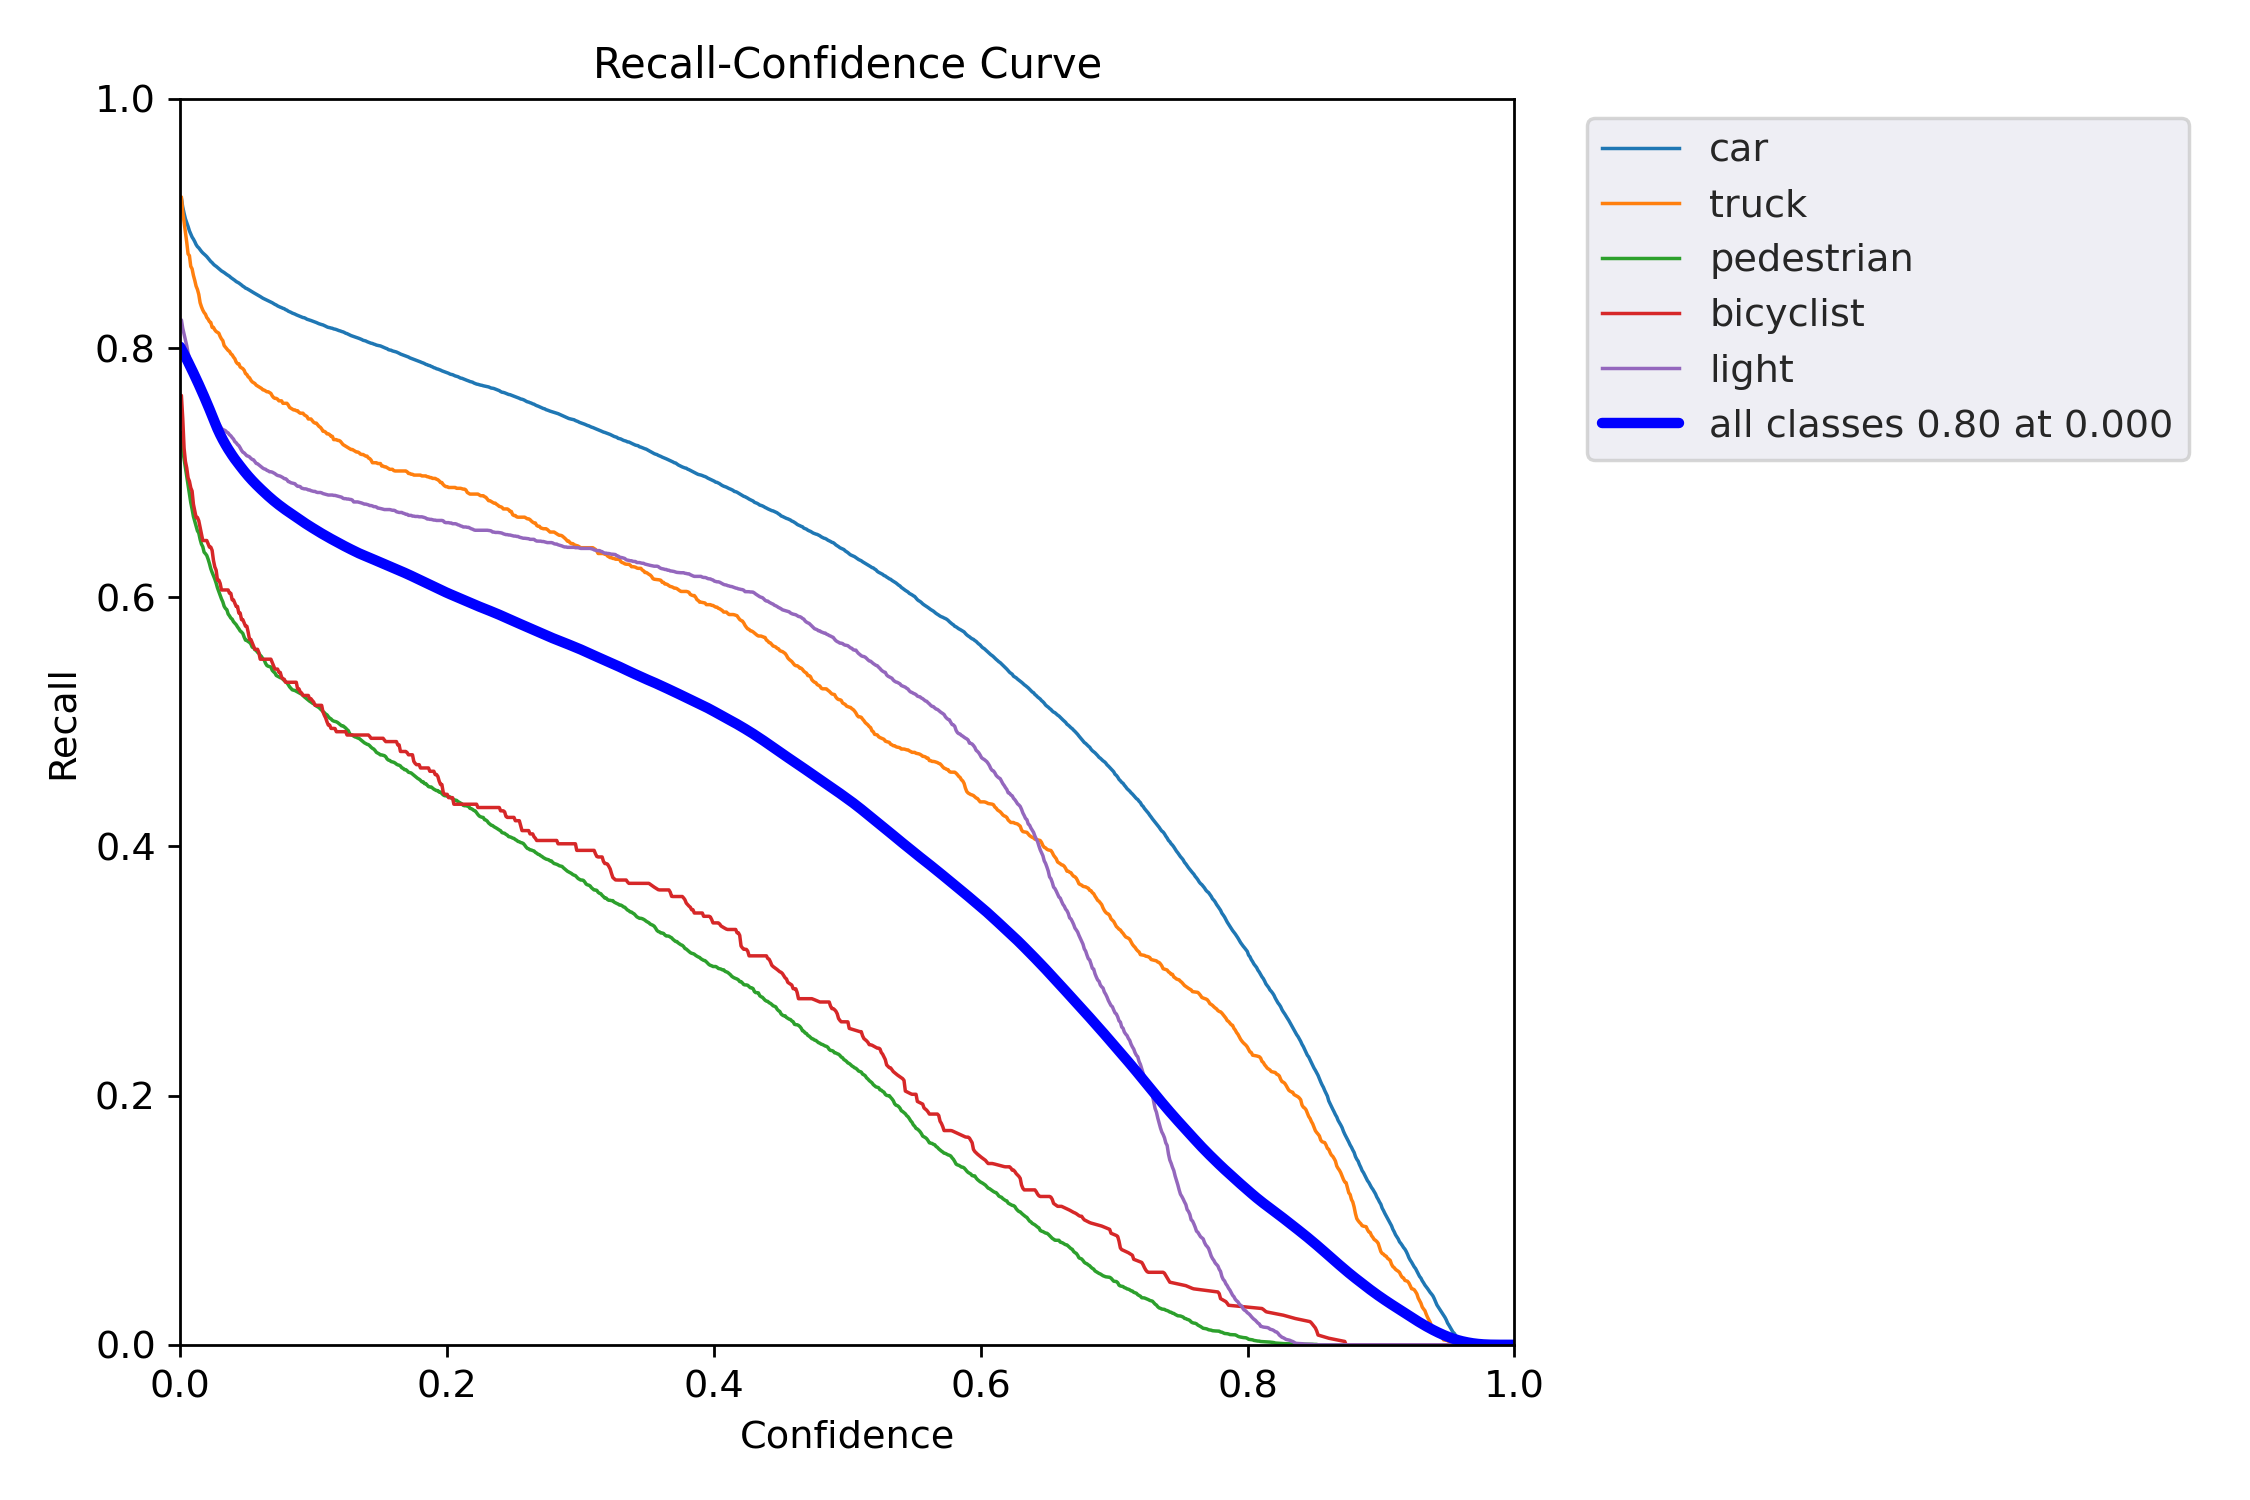

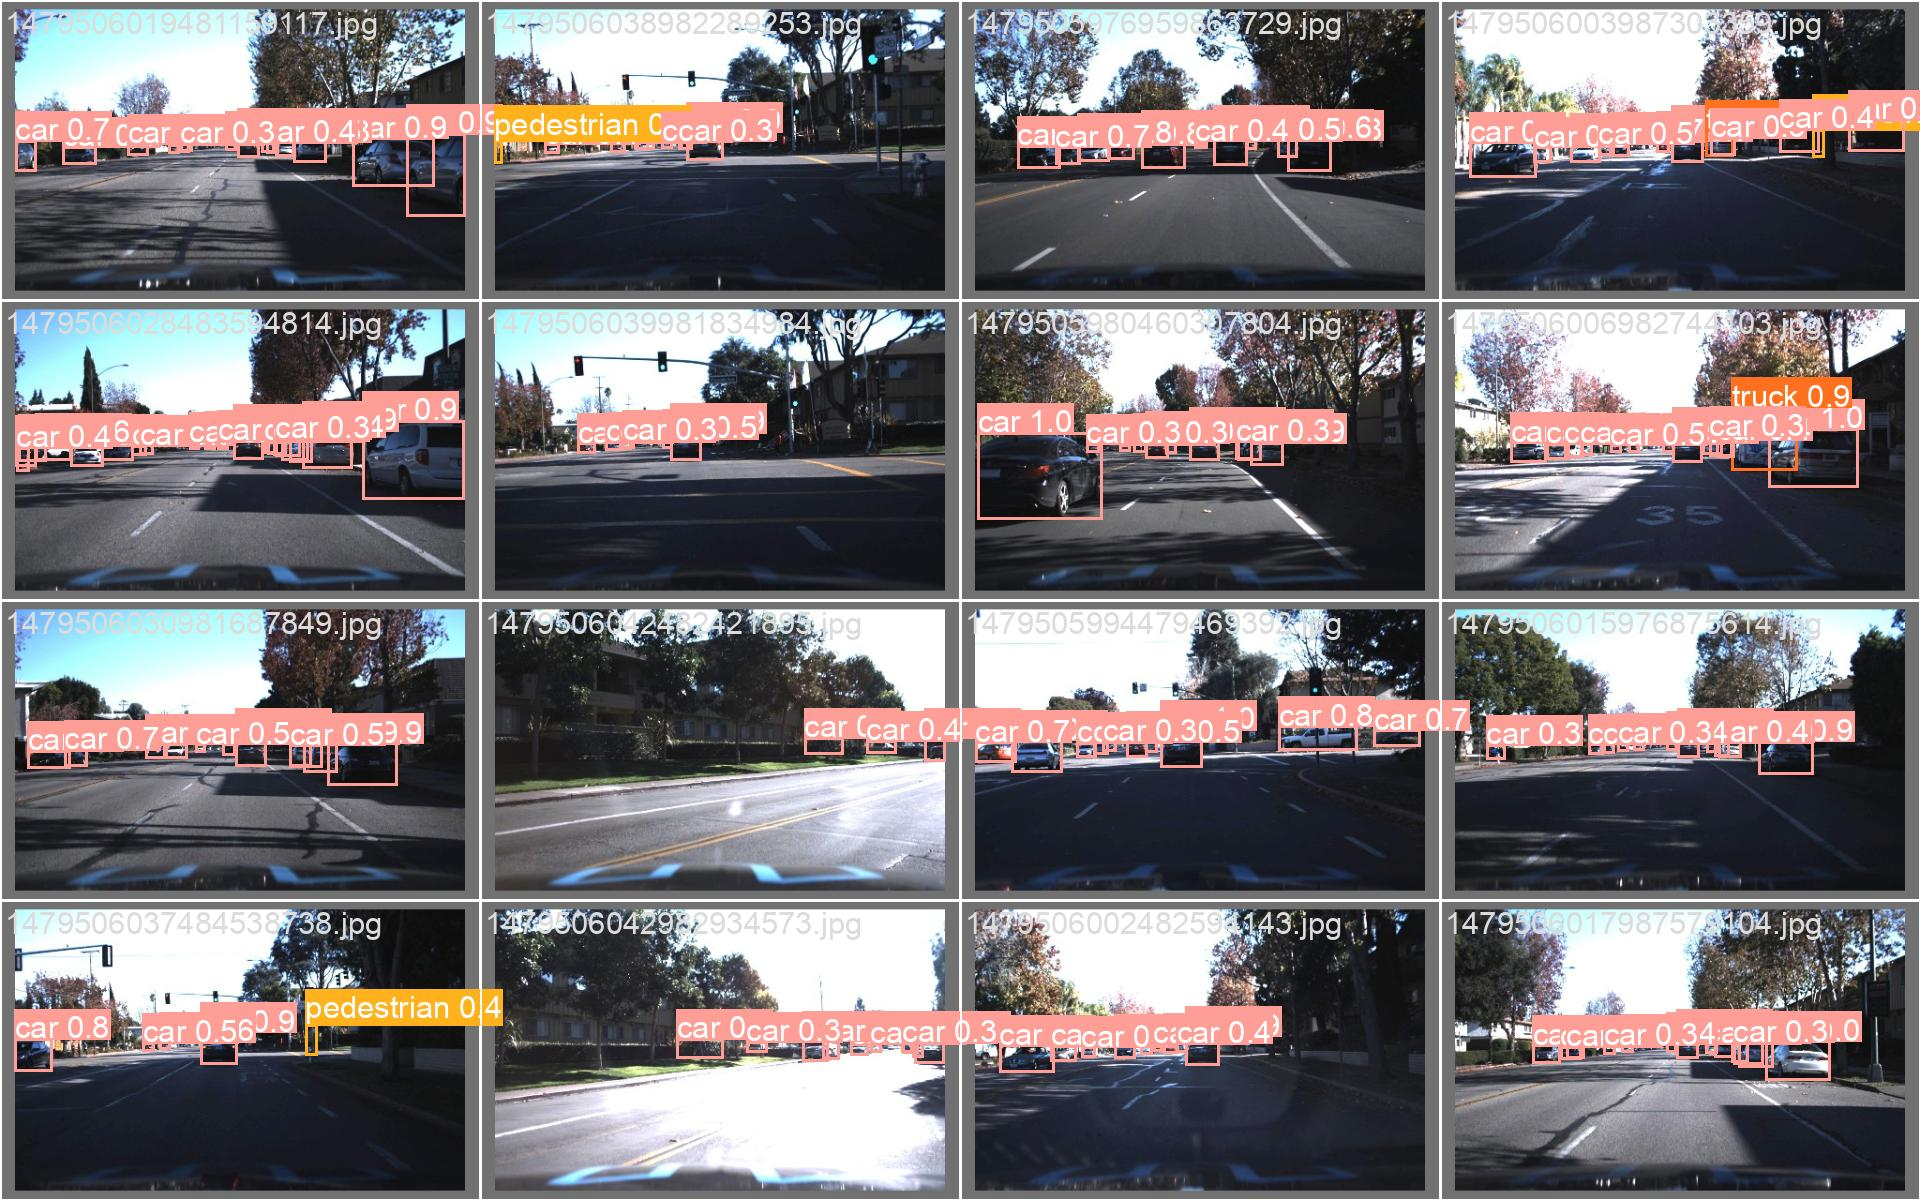

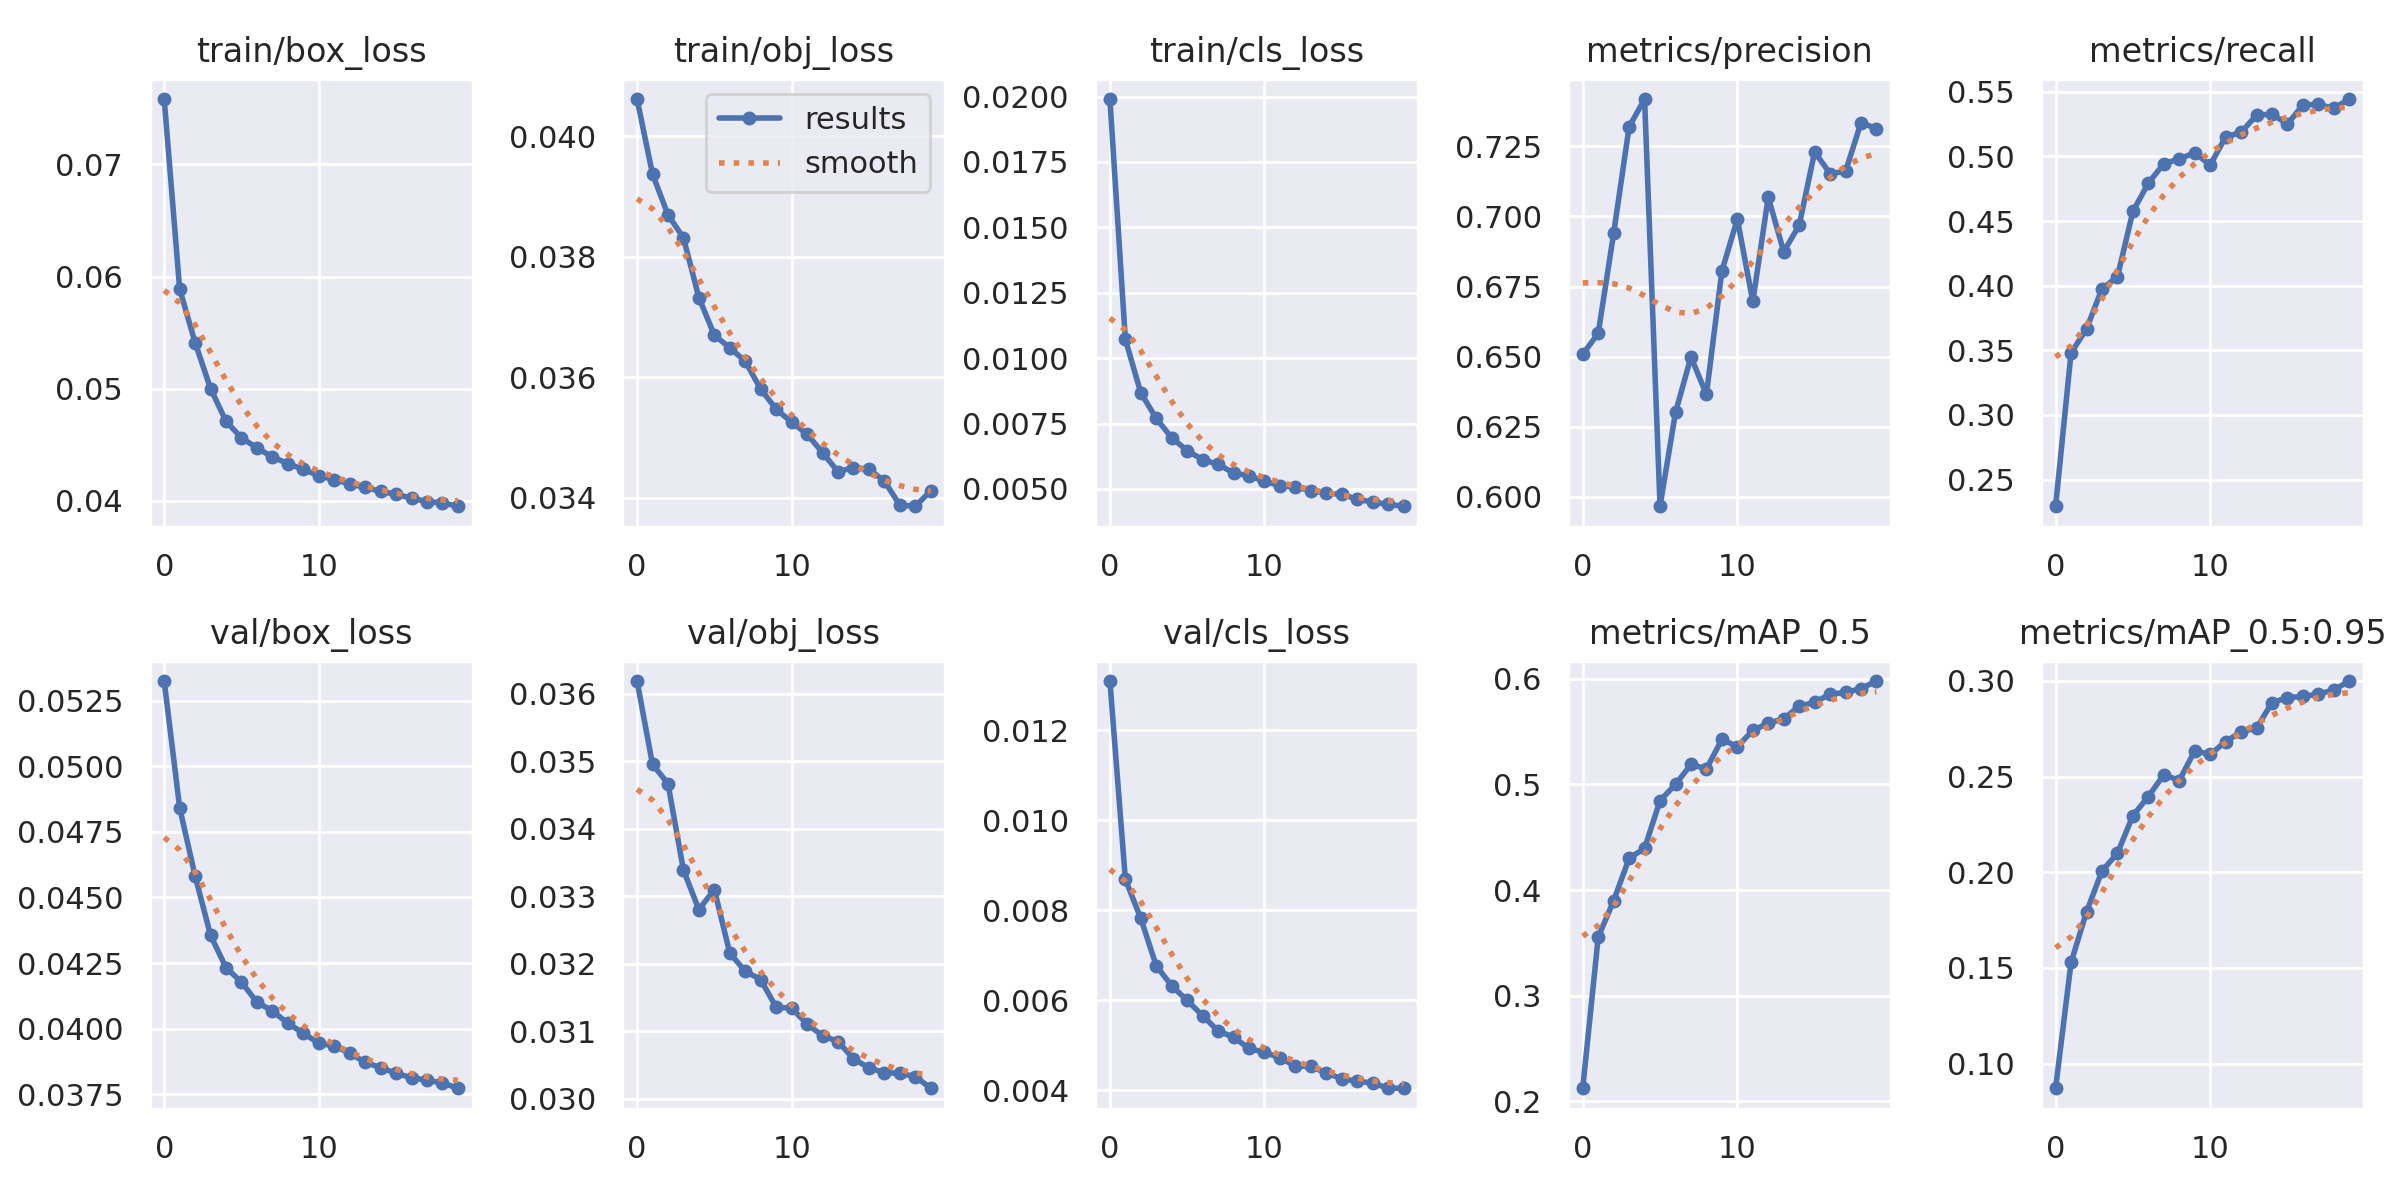

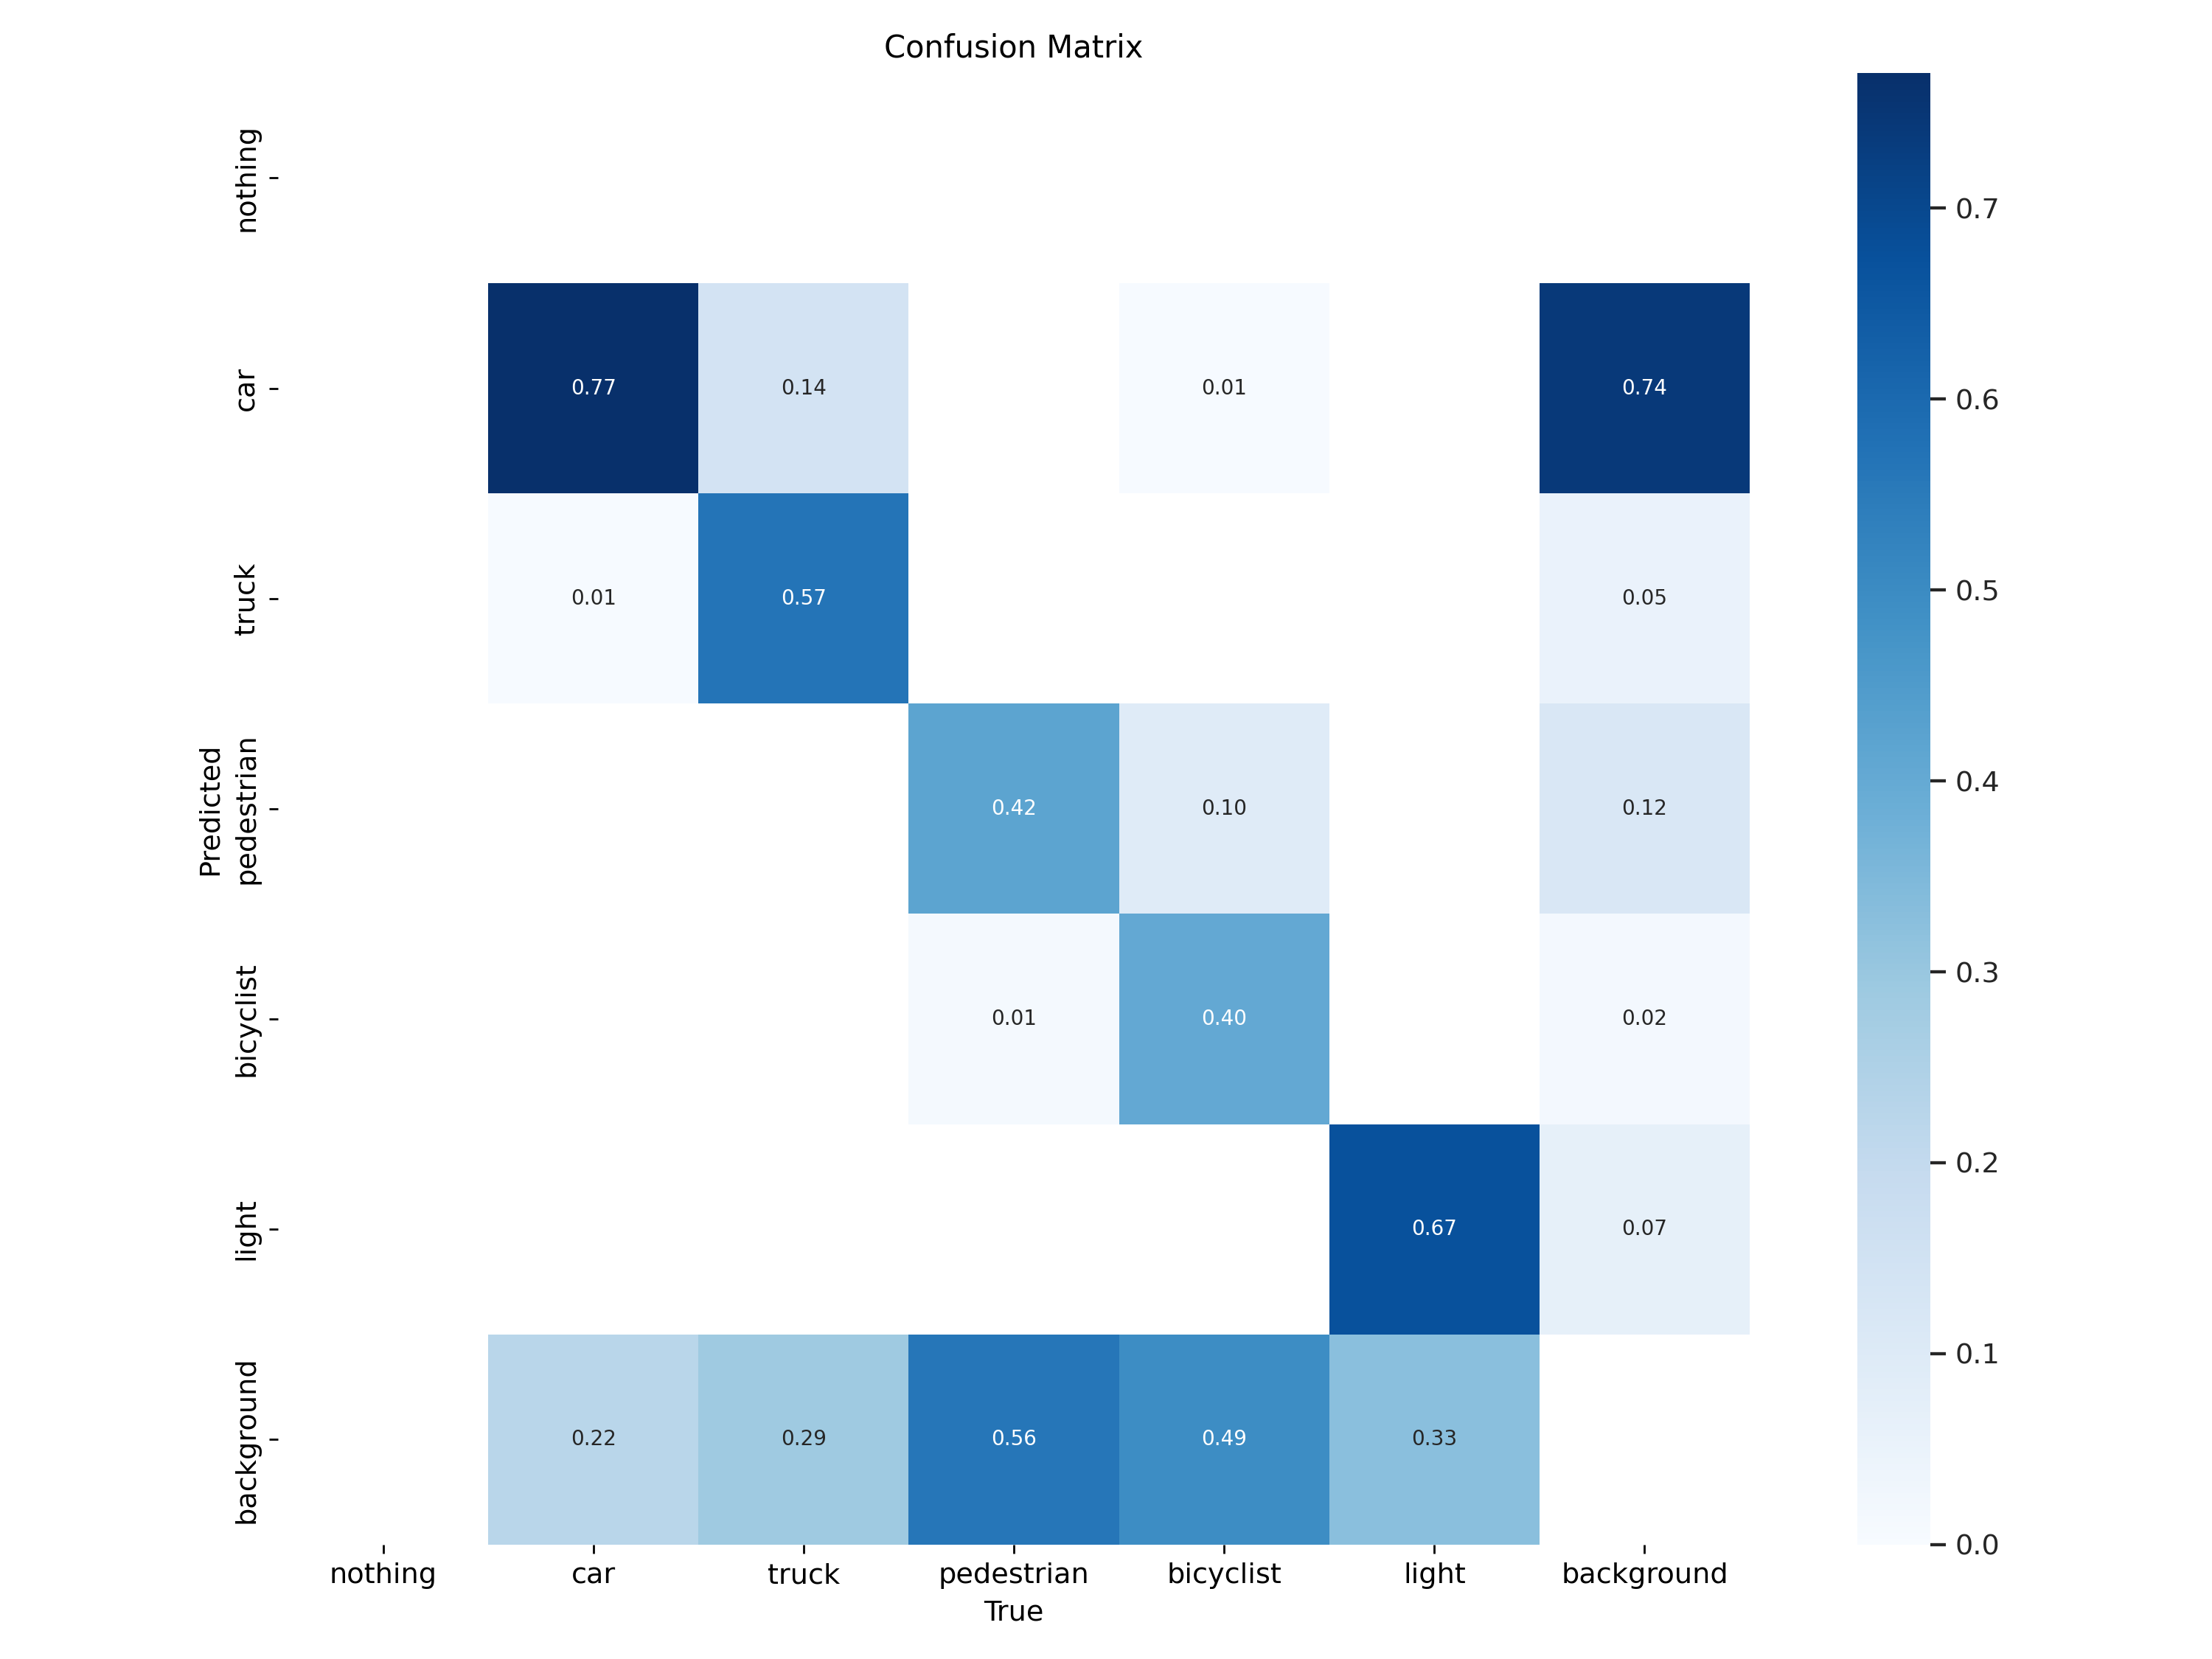

In [23]:
# prompt: using thepast cell python code(imgshow(os.path.join(ROOT_DIR,'/content/kaggle/yolov8/ultralytics/runs/detect/train3/train_batch0.jpg'), width = 600)). display all image (jpg and png)

import os
from IPython.display import Image, display

# Get a list of all files in the directory
files = os.listdir('/kaggle/working/yolov5/runs/train/exp')

# Filter the list to only include JPG and PNG files
image_files = [file for file in files if file.endswith('.jpg') or file.endswith('.png')]

# Display each image
for image_file in image_files:
    display(Image(filename=os.path.join('/kaggle/working/yolov5/runs/train/exp', image_file)))



### Architecture

In [44]:
import torch
from models.yolo import Model

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load YOLOv5n model
model = Model('/kaggle/working/yolov5/models/yolov5n.yaml', ch=3, nc=80).to(device)

# Print model summary
print(model)


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  8                -1  1    296448  

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     

# Tuning the hyperparameters

In [31]:
# Set the W&B API key as an environment variable
import os
os.environ['WANDB_API_KEY'] = 'aae7737217e31289ebb402d7aee05fe5318de5d0'

# Import and login to W&B
import wandb
wandb.login(key=os.environ['WANDB_API_KEY'])
#Tune the model
from ultralytics import YOLO

# Initialize the YOLO model
model = YOLO("yolov5n.pt")

# Tune hyperparameters 
model.tune(data="/kaggle/working/yolov5/data/dataset2.yaml", epochs=10, 
           imgsz=480, batch=32, lr0=0.0033 , plots=False, save=False, val=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune7'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.0033, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improv

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_153029-kbi9ecl3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train26
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/kbi9ecl3


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 69.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:17<00:00, 992.21it/s] 


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:04<00:00, 1014.43it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/data/images/validation/labels.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0033' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train26
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=

       1/10      2.53G      1.621      1.582      1.071         22        480: 100%|██████████| 556/556 [01:52<00:00,  4.94it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.531      1.043      1.056         12        480: 100%|██████████| 556/556 [01:47<00:00,  5.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.509     0.9653      1.049         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.487     0.9254      1.041         33        480: 100%|██████████| 556/556 [01:45<00:00,  5.28it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.452     0.8839       1.03         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.32it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      1.427     0.8534       1.02         38        480: 100%|██████████| 556/556 [01:44<00:00,  5.30it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.407     0.8253      1.013         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.34it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.58G      1.385     0.8044      1.005         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.365     0.7798     0.9957         22        480: 100%|██████████| 556/556 [01:45<00:00,  5.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.344     0.7592     0.9891         30        480: 100%|██████████| 556/556 [01:45<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.64it/s]


                   all       4477      33508      0.671       0.51      0.559      0.298

10 epochs completed in 0.303 hours.
Optimizer stripped from runs/detect/train26/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train26/weights/best.pt, 5.2MB

Validating runs/detect/train26/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:17<00:00,  4.08it/s]


                   all       4477      33508      0.671       0.51       0.56      0.298
                   car       4403      24803      0.798      0.712      0.787      0.478
                 truck       1109       1510      0.701      0.619      0.669      0.435
            pedestrian       1154       3386      0.633      0.349      0.417      0.171
             bicyclist        234        378      0.434      0.278      0.292       0.13
                 light        984       3431       0.79      0.594      0.633      0.278
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 1
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_155020-x9uk6o9c
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train27
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/x9uk6o9c


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00273' and 'momentum=0.93061' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00029), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train27
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      

       1/10      2.56G      1.432      1.079     0.9469         22        480: 100%|██████████| 556/556 [01:54<00:00,  4.85it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.353     0.7092      0.935         12        480: 100%|██████████| 556/556 [01:47<00:00,  5.18it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.327     0.6542     0.9279         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.311     0.6292     0.9206         34        480: 100%|██████████| 556/556 [01:43<00:00,  5.39it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.282     0.5999     0.9099         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      1.261       0.58     0.9022         38        480: 100%|██████████| 556/556 [01:43<00:00,  5.38it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.239      0.561     0.8944         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.58G      1.221     0.5474     0.8875         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.32it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.204     0.5321     0.8803         22        480: 100%|██████████| 556/556 [01:43<00:00,  5.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.183     0.5174     0.8745         30        480: 100%|██████████| 556/556 [01:43<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


                   all       4477      33508      0.681      0.516      0.563      0.302

10 epochs completed in 0.300 hours.
Optimizer stripped from runs/detect/train27/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train27/weights/best.pt, 5.2MB

Validating runs/detect/train27/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:16<00:00,  4.19it/s]


                   all       4477      33508      0.679      0.516      0.562      0.302
                   car       4403      24803      0.802      0.713      0.788      0.483
                 truck       1109       1510      0.746      0.586      0.654       0.43
            pedestrian       1154       3386      0.649      0.336      0.415      0.174
             bicyclist        234        378      0.429      0.349      0.322      0.141
                 light        984       3431       0.77      0.593       0.63       0.28
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 2
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_160935-y6ov868j
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train28
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/y6ov868j


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00259' and 'momentum=0.93061' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00031), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train28
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      

       1/10      2.56G      1.429      1.164     0.9873         22        480: 100%|██████████| 556/556 [01:54<00:00,  4.87it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.352     0.7659     0.9753         12        480: 100%|██████████| 556/556 [01:46<00:00,  5.20it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.53G      1.326     0.7049     0.9664         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.309      0.679     0.9592         34        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.54G      1.281     0.6474     0.9493         35        480: 100%|██████████| 556/556 [01:42<00:00,  5.41it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.58G      1.259     0.6251     0.9407         38        480: 100%|██████████| 556/556 [01:43<00:00,  5.38it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.53G      1.236     0.6045     0.9322         35        480: 100%|██████████| 556/556 [01:42<00:00,  5.41it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.57G      1.218     0.5881      0.925         35        480: 100%|██████████| 556/556 [01:42<00:00,  5.42it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.53G      1.201     0.5707      0.917         22        480: 100%|██████████| 556/556 [01:42<00:00,  5.41it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.56G      1.182      0.556     0.9122         30        480: 100%|██████████| 556/556 [01:43<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.68it/s]


                   all       4477      33508      0.695      0.509      0.563      0.302

10 epochs completed in 0.299 hours.
Optimizer stripped from runs/detect/train28/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train28/weights/best.pt, 5.2MB

Validating runs/detect/train28/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:16<00:00,  4.22it/s]


                   all       4477      33508      0.696      0.509      0.563      0.302
                   car       4403      24803      0.812      0.706      0.786       0.48
                 truck       1109       1510      0.766      0.582      0.659      0.437
            pedestrian       1154       3386      0.633      0.343      0.413      0.172
             bicyclist        234        378      0.487      0.323      0.326      0.142
                 light        984       3431      0.784      0.591      0.629      0.278
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 3
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_162849-bjmpfzid
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train29
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/bjmpfzid


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00358' and 'momentum=0.89731' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00029), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train29
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      

       1/10      2.56G      1.585      1.308      1.175         22        480: 100%|██████████| 556/556 [01:54<00:00,  4.88it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.501     0.8643       1.16         12        480: 100%|██████████| 556/556 [01:46<00:00,  5.22it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.472      0.796      1.152         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.456     0.7685      1.146         33        480: 100%|██████████| 556/556 [01:43<00:00,  5.38it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.421      0.732      1.131         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      1.398     0.7058      1.121         36        480: 100%|██████████| 556/556 [01:43<00:00,  5.38it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.373     0.6844      1.111         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.34it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.58G      1.353     0.6647      1.102         35        480: 100%|██████████| 556/556 [01:42<00:00,  5.40it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.331     0.6444      1.091         22        480: 100%|██████████| 556/556 [01:44<00:00,  5.32it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.312     0.6285      1.085         30        480: 100%|██████████| 556/556 [01:48<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:20<00:00,  3.44it/s]


                   all       4477      33508      0.682      0.509      0.558      0.301

10 epochs completed in 0.302 hours.
Optimizer stripped from runs/detect/train29/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train29/weights/best.pt, 5.2MB

Validating runs/detect/train29/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:18<00:00,  3.88it/s]


                   all       4477      33508      0.683       0.51      0.558      0.301
                   car       4403      24803      0.784      0.717      0.786      0.481
                 truck       1109       1510      0.721      0.591      0.659       0.43
            pedestrian       1154       3386      0.633      0.353      0.408      0.173
             bicyclist        234        378        0.5      0.299      0.311      0.142
                 light        984       3431      0.777      0.589      0.628       0.28
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 4
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_164816-azvnvpdi
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train30
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/azvnvpdi


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00305' and 'momentum=0.91086' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00031), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train30
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      

       1/10      2.56G       1.51      1.013     0.9342         22        480: 100%|██████████| 556/556 [02:00<00:00,  4.61it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.427     0.6664     0.9226         12        480: 100%|██████████| 556/556 [01:51<00:00,  5.00it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.396      0.608     0.9125         35        480: 100%|██████████| 556/556 [01:47<00:00,  5.19it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.382     0.5877     0.9081         34        480: 100%|██████████| 556/556 [01:47<00:00,  5.18it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.351     0.5628     0.8992         35        480: 100%|██████████| 556/556 [01:47<00:00,  5.19it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      1.326      0.542     0.8899         38        480: 100%|██████████| 556/556 [01:47<00:00,  5.17it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.306     0.5249     0.8827         35        480: 100%|██████████| 556/556 [01:48<00:00,  5.12it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.58G      1.287     0.5109     0.8756         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.25it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.266     0.4954     0.8675         22        480: 100%|██████████| 556/556 [01:44<00:00,  5.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.245     0.4815     0.8623         30        480: 100%|██████████| 556/556 [01:43<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


                   all       4477      33508      0.672      0.522      0.562      0.306

10 epochs completed in 0.309 hours.
Optimizer stripped from runs/detect/train30/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train30/weights/best.pt, 5.2MB

Validating runs/detect/train30/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:16<00:00,  4.18it/s]


                   all       4477      33508      0.674      0.522      0.563      0.306
                   car       4403      24803       0.77       0.73      0.788      0.483
                 truck       1109       1510      0.743      0.593      0.662      0.435
            pedestrian       1154       3386        0.6      0.381      0.417      0.177
             bicyclist        234        378      0.492      0.312      0.312      0.151
                 light        984       3431      0.768      0.596      0.633      0.284
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.7ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 5
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_170806-kij2gbjr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train31
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/kij2gbjr


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0032' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00048), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train31
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epo

       1/10      2.56G      1.611      1.365      1.067         22        480: 100%|██████████| 556/556 [01:54<00:00,  4.84it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.524     0.8968      1.055         12        480: 100%|██████████| 556/556 [01:50<00:00,  5.01it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.485     0.8146      1.042         36        480: 100%|██████████| 556/556 [01:45<00:00,  5.28it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.475     0.7908      1.038         34        480: 100%|██████████| 556/556 [01:46<00:00,  5.21it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.444     0.7557      1.028         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.33it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      1.417       0.73      1.016         38        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.396     0.7048      1.009         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.58G      1.374     0.6856      1.001         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.32it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.351      0.665     0.9901         22        480: 100%|██████████| 556/556 [01:43<00:00,  5.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G       1.33     0.6471     0.9848         30        480: 100%|██████████| 556/556 [01:44<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.63it/s]


                   all       4477      33508      0.695       0.51      0.566      0.303

10 epochs completed in 0.303 hours.
Optimizer stripped from runs/detect/train31/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train31/weights/best.pt, 5.2MB

Validating runs/detect/train31/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:16<00:00,  4.21it/s]


                   all       4477      33508      0.696      0.509      0.566      0.303
                   car       4403      24803      0.795      0.713      0.787      0.481
                 truck       1109       1510      0.755      0.583      0.667      0.438
            pedestrian       1154       3386       0.63      0.357      0.418      0.175
             bicyclist        234        378      0.498      0.294      0.315      0.141
                 light        984       3431      0.802      0.597      0.644      0.282
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 6
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_172735-ax9ev8zt
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train32
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/ax9ev8zt


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00309' and 'momentum=0.94041' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00021), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train32
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      

       1/10      2.56G      1.506     0.9076     0.9651         22        480: 100%|██████████| 556/556 [01:53<00:00,  4.91it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.426     0.6007     0.9515         12        480: 100%|██████████| 556/556 [01:45<00:00,  5.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.53G        1.4     0.5582     0.9453         36        480: 100%|██████████| 556/556 [01:42<00:00,  5.41it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.375     0.5312     0.9349         34        480: 100%|██████████| 556/556 [01:42<00:00,  5.41it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.54G      1.345     0.5091     0.9258         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.58G      1.321     0.4908     0.9165         38        480: 100%|██████████| 556/556 [01:44<00:00,  5.32it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.53G      1.298     0.4758     0.9097         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.57G       1.28     0.4636     0.9028         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.262     0.4488     0.8946         22        480: 100%|██████████| 556/556 [01:44<00:00,  5.34it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.56G      1.243     0.4385     0.8899         30        480: 100%|██████████| 556/556 [01:43<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:18<00:00,  3.71it/s]


                   all       4477      33508      0.676      0.515      0.559      0.304

10 epochs completed in 0.299 hours.
Optimizer stripped from runs/detect/train32/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train32/weights/best.pt, 5.2MB

Validating runs/detect/train32/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:16<00:00,  4.13it/s]


                   all       4477      33508      0.676      0.514      0.559      0.304
                   car       4403      24803      0.786      0.722      0.788      0.484
                 truck       1109       1510      0.762      0.605      0.665      0.442
            pedestrian       1154       3386      0.578      0.369      0.404      0.175
             bicyclist        234        378      0.493      0.283      0.307      0.136
                 light        984       3431      0.759      0.592      0.629      0.284
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.7ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 7
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_174649-284123t0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train33
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/284123t0


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0032' and 'momentum=0.90541' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00031), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train33
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      E

       1/10      2.56G      1.481      1.011     0.9369         22        480: 100%|██████████| 556/556 [01:54<00:00,  4.85it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G        1.4     0.6655     0.9236         12        480: 100%|██████████| 556/556 [01:47<00:00,  5.16it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.374     0.6125     0.9149         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.35it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.357     0.5913     0.9095         34        480: 100%|██████████| 556/556 [01:46<00:00,  5.22it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.327      0.564     0.9001         35        480: 100%|██████████| 556/556 [01:46<00:00,  5.24it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      1.303     0.5417     0.8907         38        480: 100%|██████████| 556/556 [01:44<00:00,  5.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.283     0.5251     0.8829         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.26it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.58G      1.262     0.5108     0.8774         35        480: 100%|██████████| 556/556 [01:46<00:00,  5.23it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.243     0.4954     0.8687         22        480: 100%|██████████| 556/556 [01:46<00:00,  5.23it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.222     0.4827     0.8636         30        480: 100%|██████████| 556/556 [01:44<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.61it/s]


                   all       4477      33508      0.679      0.514       0.56      0.301

10 epochs completed in 0.305 hours.
Optimizer stripped from runs/detect/train33/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train33/weights/best.pt, 5.2MB

Validating runs/detect/train33/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:17<00:00,  4.00it/s]


                   all       4477      33508      0.678      0.514       0.56      0.301
                   car       4403      24803      0.784      0.722      0.788      0.482
                 truck       1109       1510      0.756      0.583      0.659      0.431
            pedestrian       1154       3386      0.608      0.366      0.411      0.174
             bicyclist        234        378      0.461      0.312      0.311      0.139
                 light        984       3431      0.782      0.587      0.631      0.279
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.7ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 8
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_180624-j1hmqpkn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train34
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/j1hmqpkn


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00275' and 'momentum=0.93061' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00032), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train34
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      

       1/10      2.56G      1.482      1.174     0.9884         22        480: 100%|██████████| 556/556 [01:56<00:00,  4.78it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.402     0.7742     0.9749         12        480: 100%|██████████| 556/556 [01:48<00:00,  5.13it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.53G      1.376     0.7172     0.9671         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.26it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.358     0.6865     0.9591         34        480: 100%|██████████| 556/556 [01:46<00:00,  5.23it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.54G      1.325     0.6538     0.9477         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.58G      1.303     0.6322       0.94         38        480: 100%|██████████| 556/556 [01:44<00:00,  5.30it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.53G       1.28     0.6124     0.9309         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.28it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.57G      1.262     0.5964     0.9237         35        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.243     0.5773     0.9154         22        480: 100%|██████████| 556/556 [01:45<00:00,  5.28it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.56G      1.225     0.5626     0.9115         30        480: 100%|██████████| 556/556 [01:43<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.62it/s]


                   all       4477      33508      0.672      0.515      0.562      0.303

10 epochs completed in 0.304 hours.
Optimizer stripped from runs/detect/train34/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train34/weights/best.pt, 5.2MB

Validating runs/detect/train34/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:17<00:00,  4.07it/s]


                   all       4477      33508      0.672      0.515      0.562      0.303
                   car       4403      24803       0.79      0.719      0.787      0.482
                 truck       1109       1510      0.732      0.602      0.668      0.439
            pedestrian       1154       3386      0.602      0.364      0.411      0.171
             bicyclist        234        378      0.454      0.297      0.301      0.135
                 light        984       3431       0.78      0.592      0.642      0.286
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.7ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 9
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'show

wandb: Currently logged in as: johnsixian01 (boonsx). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20240610_182558-qv7hyhe3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train35
wandb: ⭐️ View project at https://wandb.ai/boonsx/YOLOv8
wandb: 🚀 View run at https://wandb.ai/boonsx/YOLOv8/runs/qv7hyhe3


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/data/images/train/labels.cache... 17764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17764/17764 [00:00<?, ?it/s]


train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020832210646675.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478020944220115330.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732457442720557.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/data/images/train/images/1478732688555973177.jpg: 1 duplicate labels removed
t

val: Scanning /kaggle/working/data/images/validation/labels.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478731920661488084.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1478899002718297706.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/data/images/validation/images/1479502405738686444.jpg: 1 duplicate labels removed
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00352' and 'momentum=0.89355' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00029), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train35
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      

       1/10      2.56G      1.591      1.285      1.175         22        480: 100%|██████████| 556/556 [01:54<00:00,  4.84it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.505      0.848      1.159         12        480: 100%|██████████| 556/556 [01:47<00:00,  5.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.479     0.7854      1.152         35        480: 100%|██████████| 556/556 [01:47<00:00,  5.16it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.58G      1.457     0.7541      1.145         33        480: 100%|██████████| 556/556 [01:46<00:00,  5.24it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.428     0.7195      1.131         35        480: 100%|██████████| 556/556 [01:46<00:00,  5.23it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      1.402     0.6927       1.12         36        480: 100%|██████████| 556/556 [01:45<00:00,  5.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G       1.38     0.6729      1.111         35        480: 100%|██████████| 556/556 [01:45<00:00,  5.27it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.58G      1.358     0.6535      1.102         35        480: 100%|██████████| 556/556 [01:44<00:00,  5.34it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.338     0.6344      1.092         22        480: 100%|██████████| 556/556 [01:43<00:00,  5.36it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.317     0.6177      1.085         30        480: 100%|██████████| 556/556 [01:44<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.65it/s]


                   all       4477      33508      0.686       0.51      0.561      0.302

10 epochs completed in 0.304 hours.
Optimizer stripped from runs/detect/train35/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train35/weights/best.pt, 5.2MB

Validating runs/detect/train35/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2504114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:17<00:00,  4.11it/s]


                   all       4477      33508      0.686       0.51      0.561      0.302
                   car       4403      24803      0.789       0.72      0.787      0.482
                 truck       1109       1510      0.747      0.592      0.658      0.433
            pedestrian       1154       3386      0.603      0.361      0.408      0.172
             bicyclist        234        378      0.521      0.288      0.322      0.145
                 light        984       3431      0.771      0.588      0.632      0.278
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 591, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 674, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 467, in _do_train
    self.run_callbacks("on_train_end")
  F

WARNING ❌️ training failure for hyperparameter tuning iteration 10
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov5n.pt', 'data=/kaggle/working/yolov5/data/dataset2.yaml', 'epochs=10', 'time=None', 'patience=100', 'batch=32', 'imgsz=480', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=False', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=False', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 'agnostic_nms=False', 'classes=None', 'retina_masks=False', 'embed=None', 'sho